# Heart Disease Health Indicators Exploratory Data Analysis

## Setup
Define libraries, packages, and helper functions

In [1]:
# General Libraries
import re
import time
import json
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Helper Functions

In [2]:
def data_aggregation(df, col):
    # Aggregate the category by ID count and target sum
    # col is the feature name e.g. mh_status, stroke
    # df is the name of the dataframe
    groupby_result = df.groupby([col]).agg( 
        total_population=('id', 'count'),
        heart_disease=('target', 'sum')
    ).reset_index()
    
    # Add columns for the percentage and no_disease
    groupby_result['%heart_disease'] = round((groupby_result['heart_disease']/groupby_result['total_population'])*100, 2)
    groupby_result['no_disease'] = groupby_result['total_population'] - groupby_result['heart_disease']
    groupby_result['%no_disease'] = round((groupby_result['no_disease']/groupby_result['total_population'])*100,2)
    
    groupby_result = groupby_result.sort_values('%heart_disease', ascending=False)
    
    return groupby_result

In [3]:
def data_agg_viz(df, col, rotation=0):
    # Set figure size
    fig, ax = plt.subplots(figsize=(5, 5), dpi=400)

    # Define the data
    # col is the feature name e.g. mh_status, stroke
    # df is the name of the dataframe
    x = df[col]
    y1 = df['%heart_disease']
    y2 = df['%no_disease']

    # Plot the stacked bars
    ax.bar(x, y1, color='b', label='Heart Disease')
    ax.bar(x, y2, bottom=y1, color='grey', label='No Heart Disease')

    # Add labels to the bars
    for i, v in enumerate(y1):
        ax.text(i, (v + y2[i]) / 15, f"{v:.2f}%", color='white', ha='center', va='center')

    # Add legend
    ax.legend()

    # Add axis labels and title
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('% with Heart Disease')
    ax.set_title(f'Heart Disease by {col}')

    # Rotate x labels
    plt.xticks(rotation=rotation)

    plt.show()

## Correlation
High BP, stroke, diabetes, general health, physical health, difficulty walking, and age are the most correlated features with respect to `target`. 

In [4]:
# Load and read the data
heart_data = pd.read_csv('2021_brfss_unmapped_nodup_heart_disease_health_indicators.csv')
heart_data.head()

,target,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,GenHlth,MentHlth,PhysHlth,DiffWalk,DepressiveDisorder,MentHlthStatus,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,1.0,...,5.0,10.0,20.0,0.0,0.0,2.0,0.0,11.0,4.0,5.0
1,1.0,1.0,1.0,1.0,28.0,0.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,4.0,3.0
2,0.0,1.0,0.0,1.0,33.0,0.0,0.0,2.0,1.0,1.0,...,2.0,10.0,0.0,0.0,0.0,2.0,0.0,9.0,4.0,7.0
3,1.0,0.0,0.0,1.0,29.0,0.0,1.0,2.0,1.0,1.0,...,5.0,0.0,30.0,1.0,0.0,1.0,1.0,12.0,3.0,4.0
4,0.0,0.0,1.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,1.0,1.0,13.0,5.0,6.0


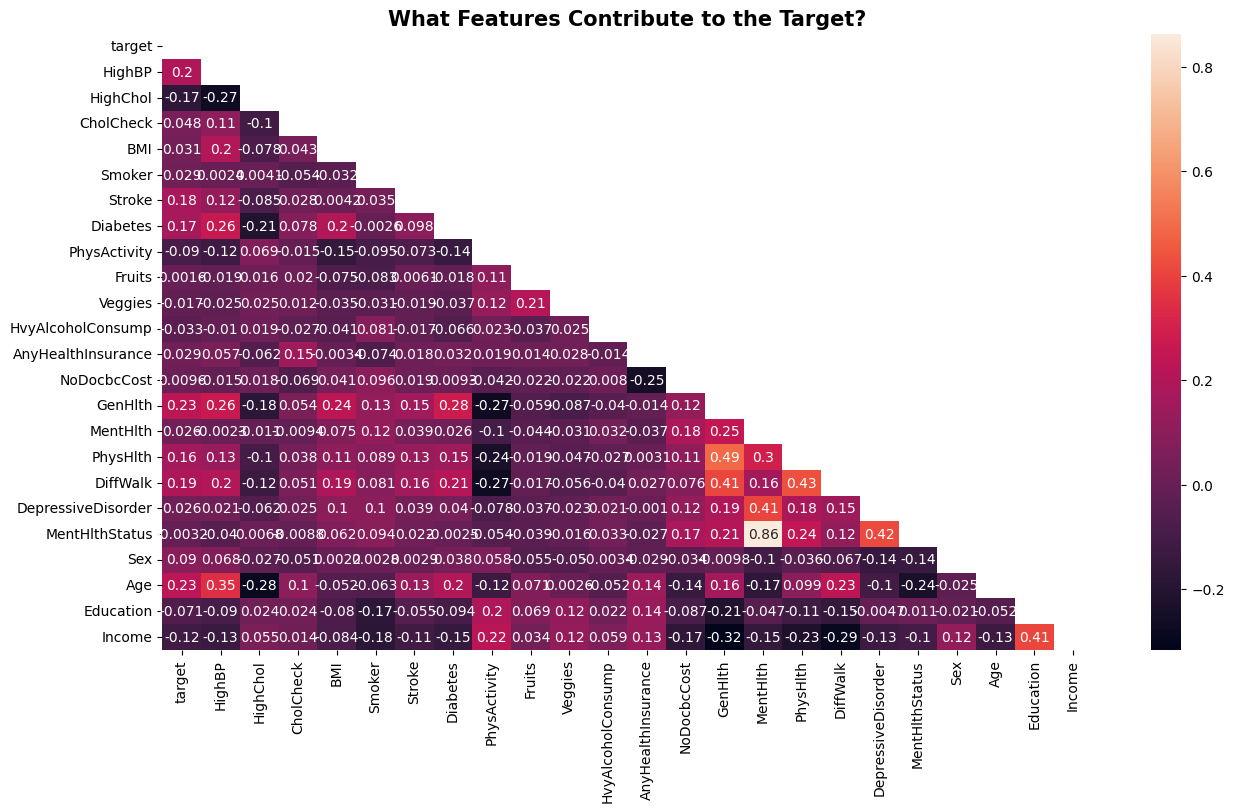

In [5]:
corr = heart_data.corr()
fig, ax = plt.subplots(figsize=(15, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, annot= True, mask=mask)
ax.set_title("What Features Contribute to the Target?", fontsize=15, y=1,
             weight='bold')
plt.show()

In [6]:
heart_data_cl = pd.read_csv('2021_brfss_clean_heart_disease_health_indicators.csv')
heart_data_cl.head(2)

,target,mental_health,physical_health,high_bp,high_chol,chol_check,bmi_category,smoker,stroke,diabetes_category,...,health_insurance,no_doc_cost,general_health,difficult_walk,depressive_disorder,mh_status,sex,age_grp,educ_grp,income_grp
0,0,10,20,No,No,Yes,Underweight,No,No,No or During Pregnancy,...,Yes,No,Poor,No,No,1-13 days not good,Female,70-74,Grade 12 or GED (High School Graduate),25k-35k USD
1,1,0,0,Yes,Yes,Yes,Overweight,No,No,Existing Diabetes,...,Yes,No,Very good,No,No,0 days not good,Female,70-74,Grade 12 or GED (High School Graduate),15k-20k USD


In [7]:
heart_data_cl['id']=range(1, len(heart_data_cl) + 1)
heart_data_cl.head(2)

,target,mental_health,physical_health,high_bp,high_chol,chol_check,bmi_category,smoker,stroke,diabetes_category,...,no_doc_cost,general_health,difficult_walk,depressive_disorder,mh_status,sex,age_grp,educ_grp,income_grp,id
0,0,10,20,No,No,Yes,Underweight,No,No,No or During Pregnancy,...,No,Poor,No,No,1-13 days not good,Female,70-74,Grade 12 or GED (High School Graduate),25k-35k USD,1
1,1,0,0,Yes,Yes,Yes,Overweight,No,No,Existing Diabetes,...,No,Very good,No,No,0 days not good,Female,70-74,Grade 12 or GED (High School Graduate),15k-20k USD,2


### Mental Health
Most of the users who have heart disease also have depressive disorder. This may be attributed to people experiencing depression over a long period of time may experience certain physiologic effects on the body increased cardiac reactivity (e.g., increased heart rate and blood pressure), reduced blood flow to the heart, and heightened levels of cortisol.

Source: [Heart Disease and Mental Health Disorders](https://www.cdc.gov/heartdisease/mentalhealth.htm)

#### Depressed

In [8]:
depressed = data_aggregation(heart_data_cl, 'depressive_disorder') #(dataframe, column_name)
depressed

,depressive_disorder,total_population,heart_disease,%heart_disease,no_disease,%no_disease
1,Yes,47628,5106,10.72,42522,89.28
0,No,154726,14817,9.58,139909,90.42


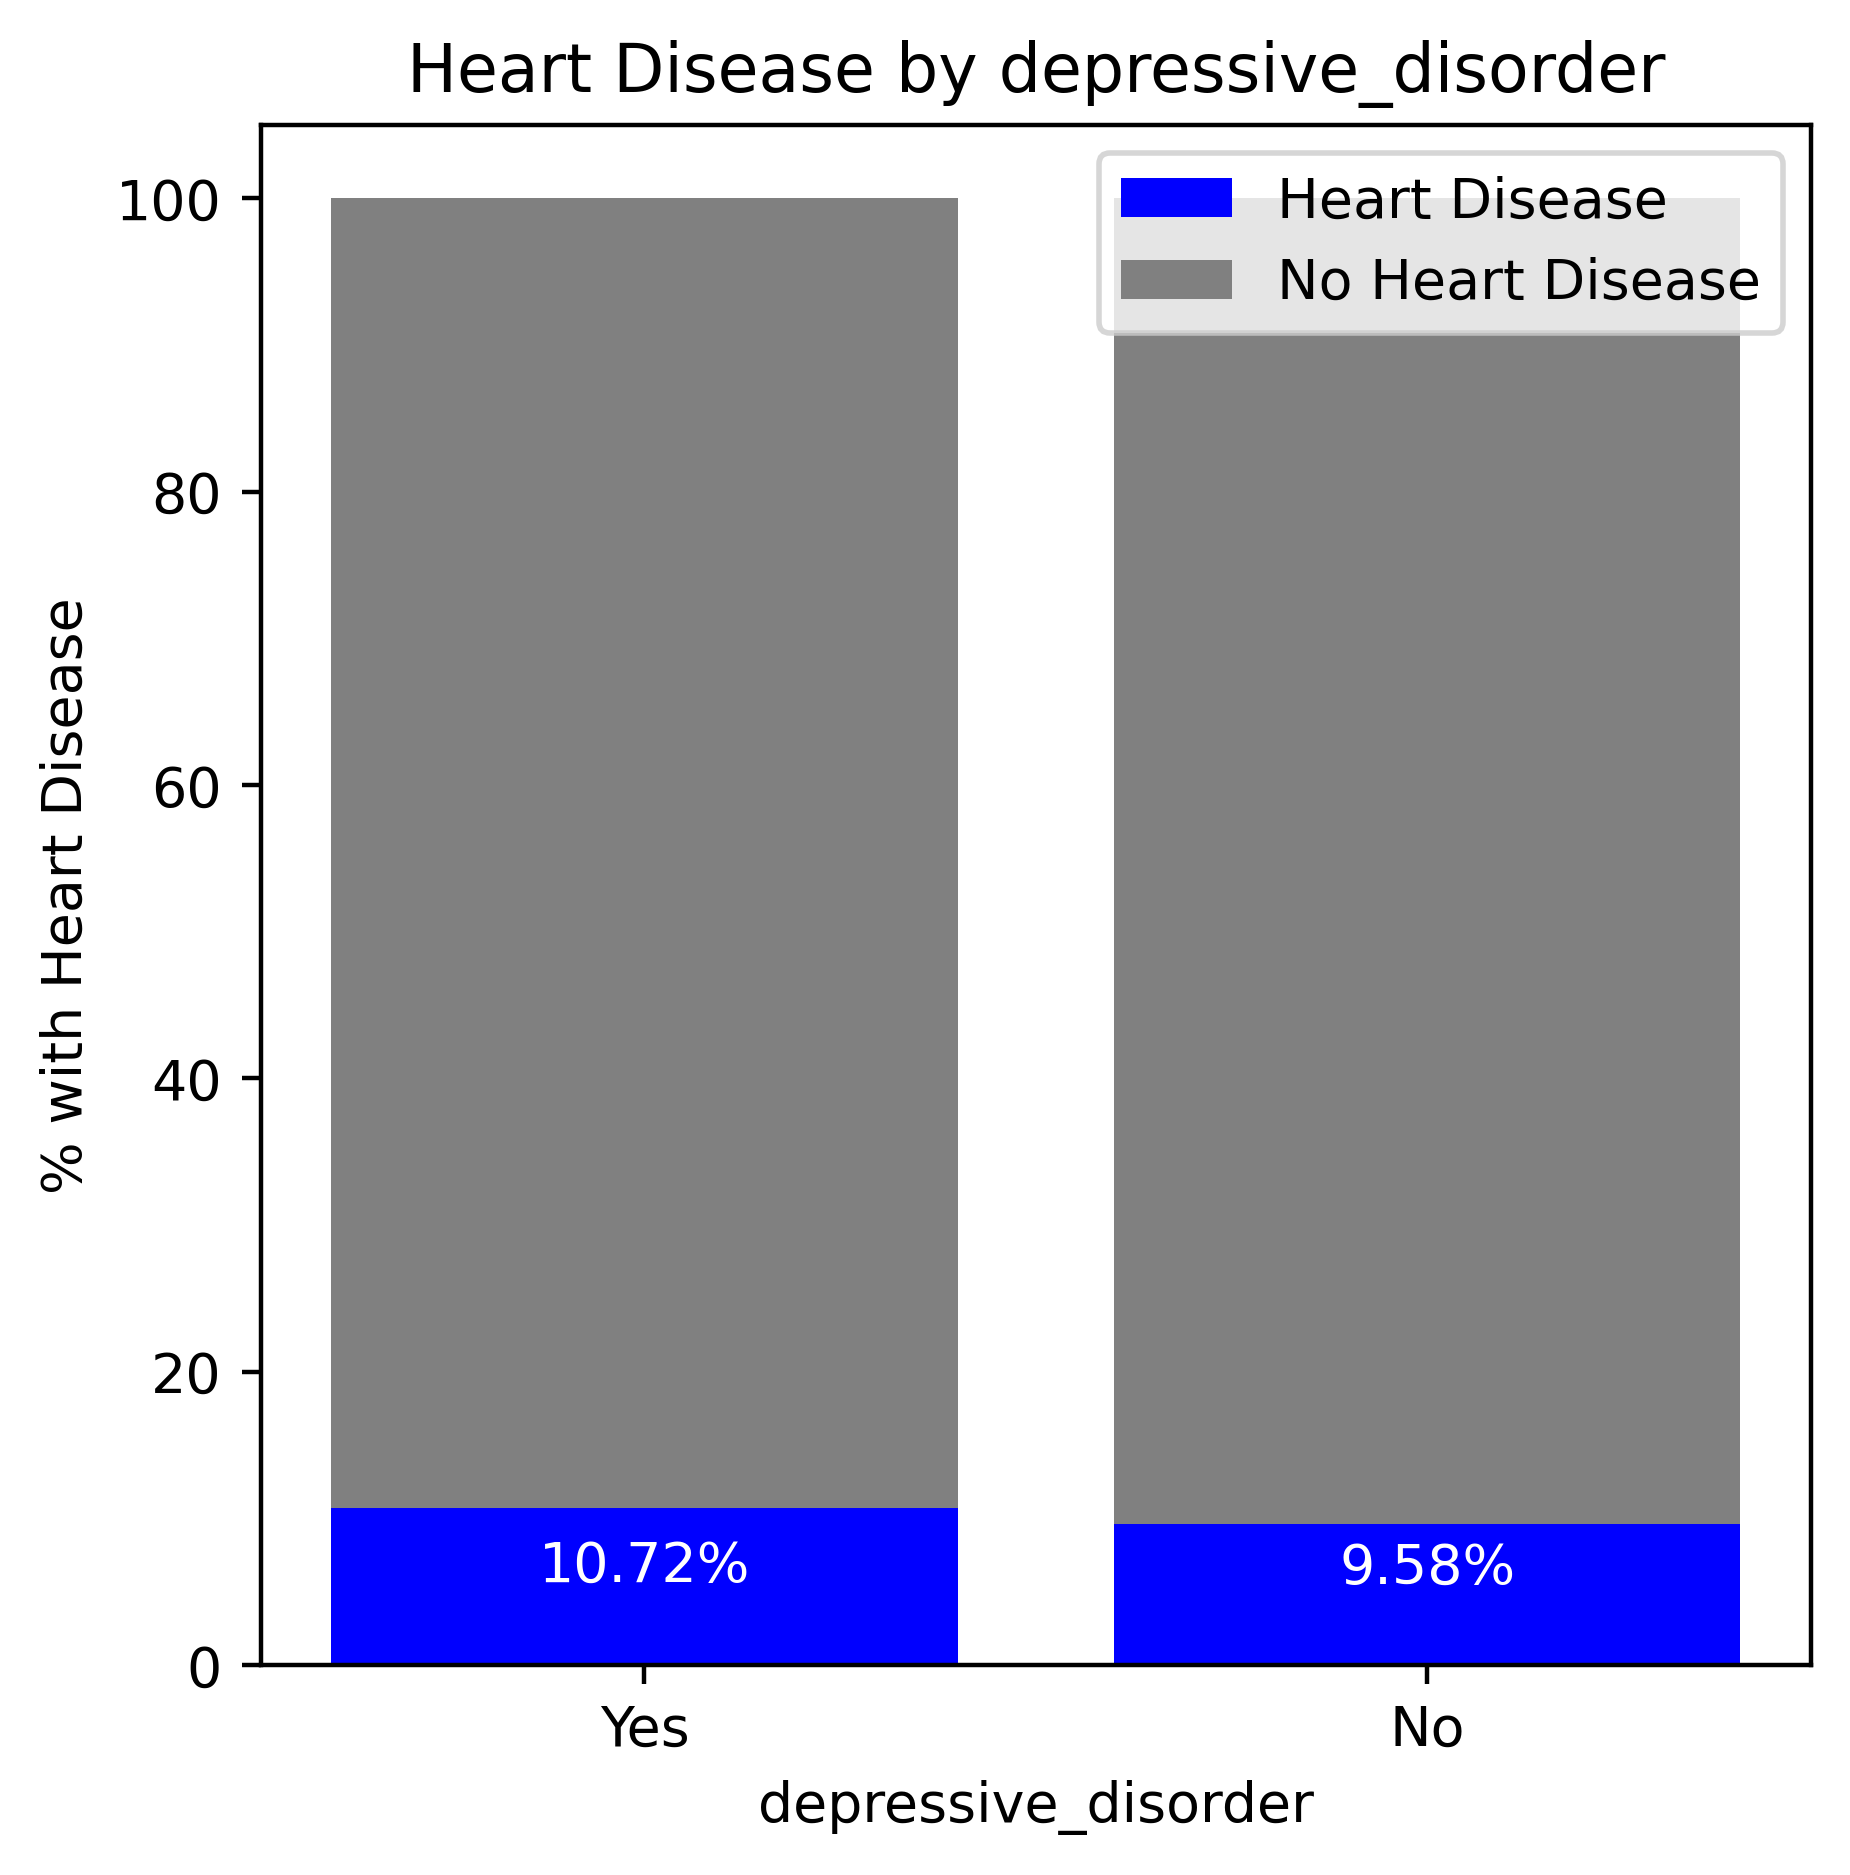

In [9]:
data_agg_viz(depressed, 'depressive_disorder')

#### Mental Health Status

In [10]:
mh = data_aggregation(heart_data_cl, 'mh_status')
mh

,mh_status,total_population,heart_disease,%heart_disease,no_disease,%no_disease
2,14+ days not good,28174,3225,11.45,24949,88.55
0,0 days not good,115816,12606,10.88,103210,89.12
1,1-13 days not good,58364,4092,7.01,54272,92.99


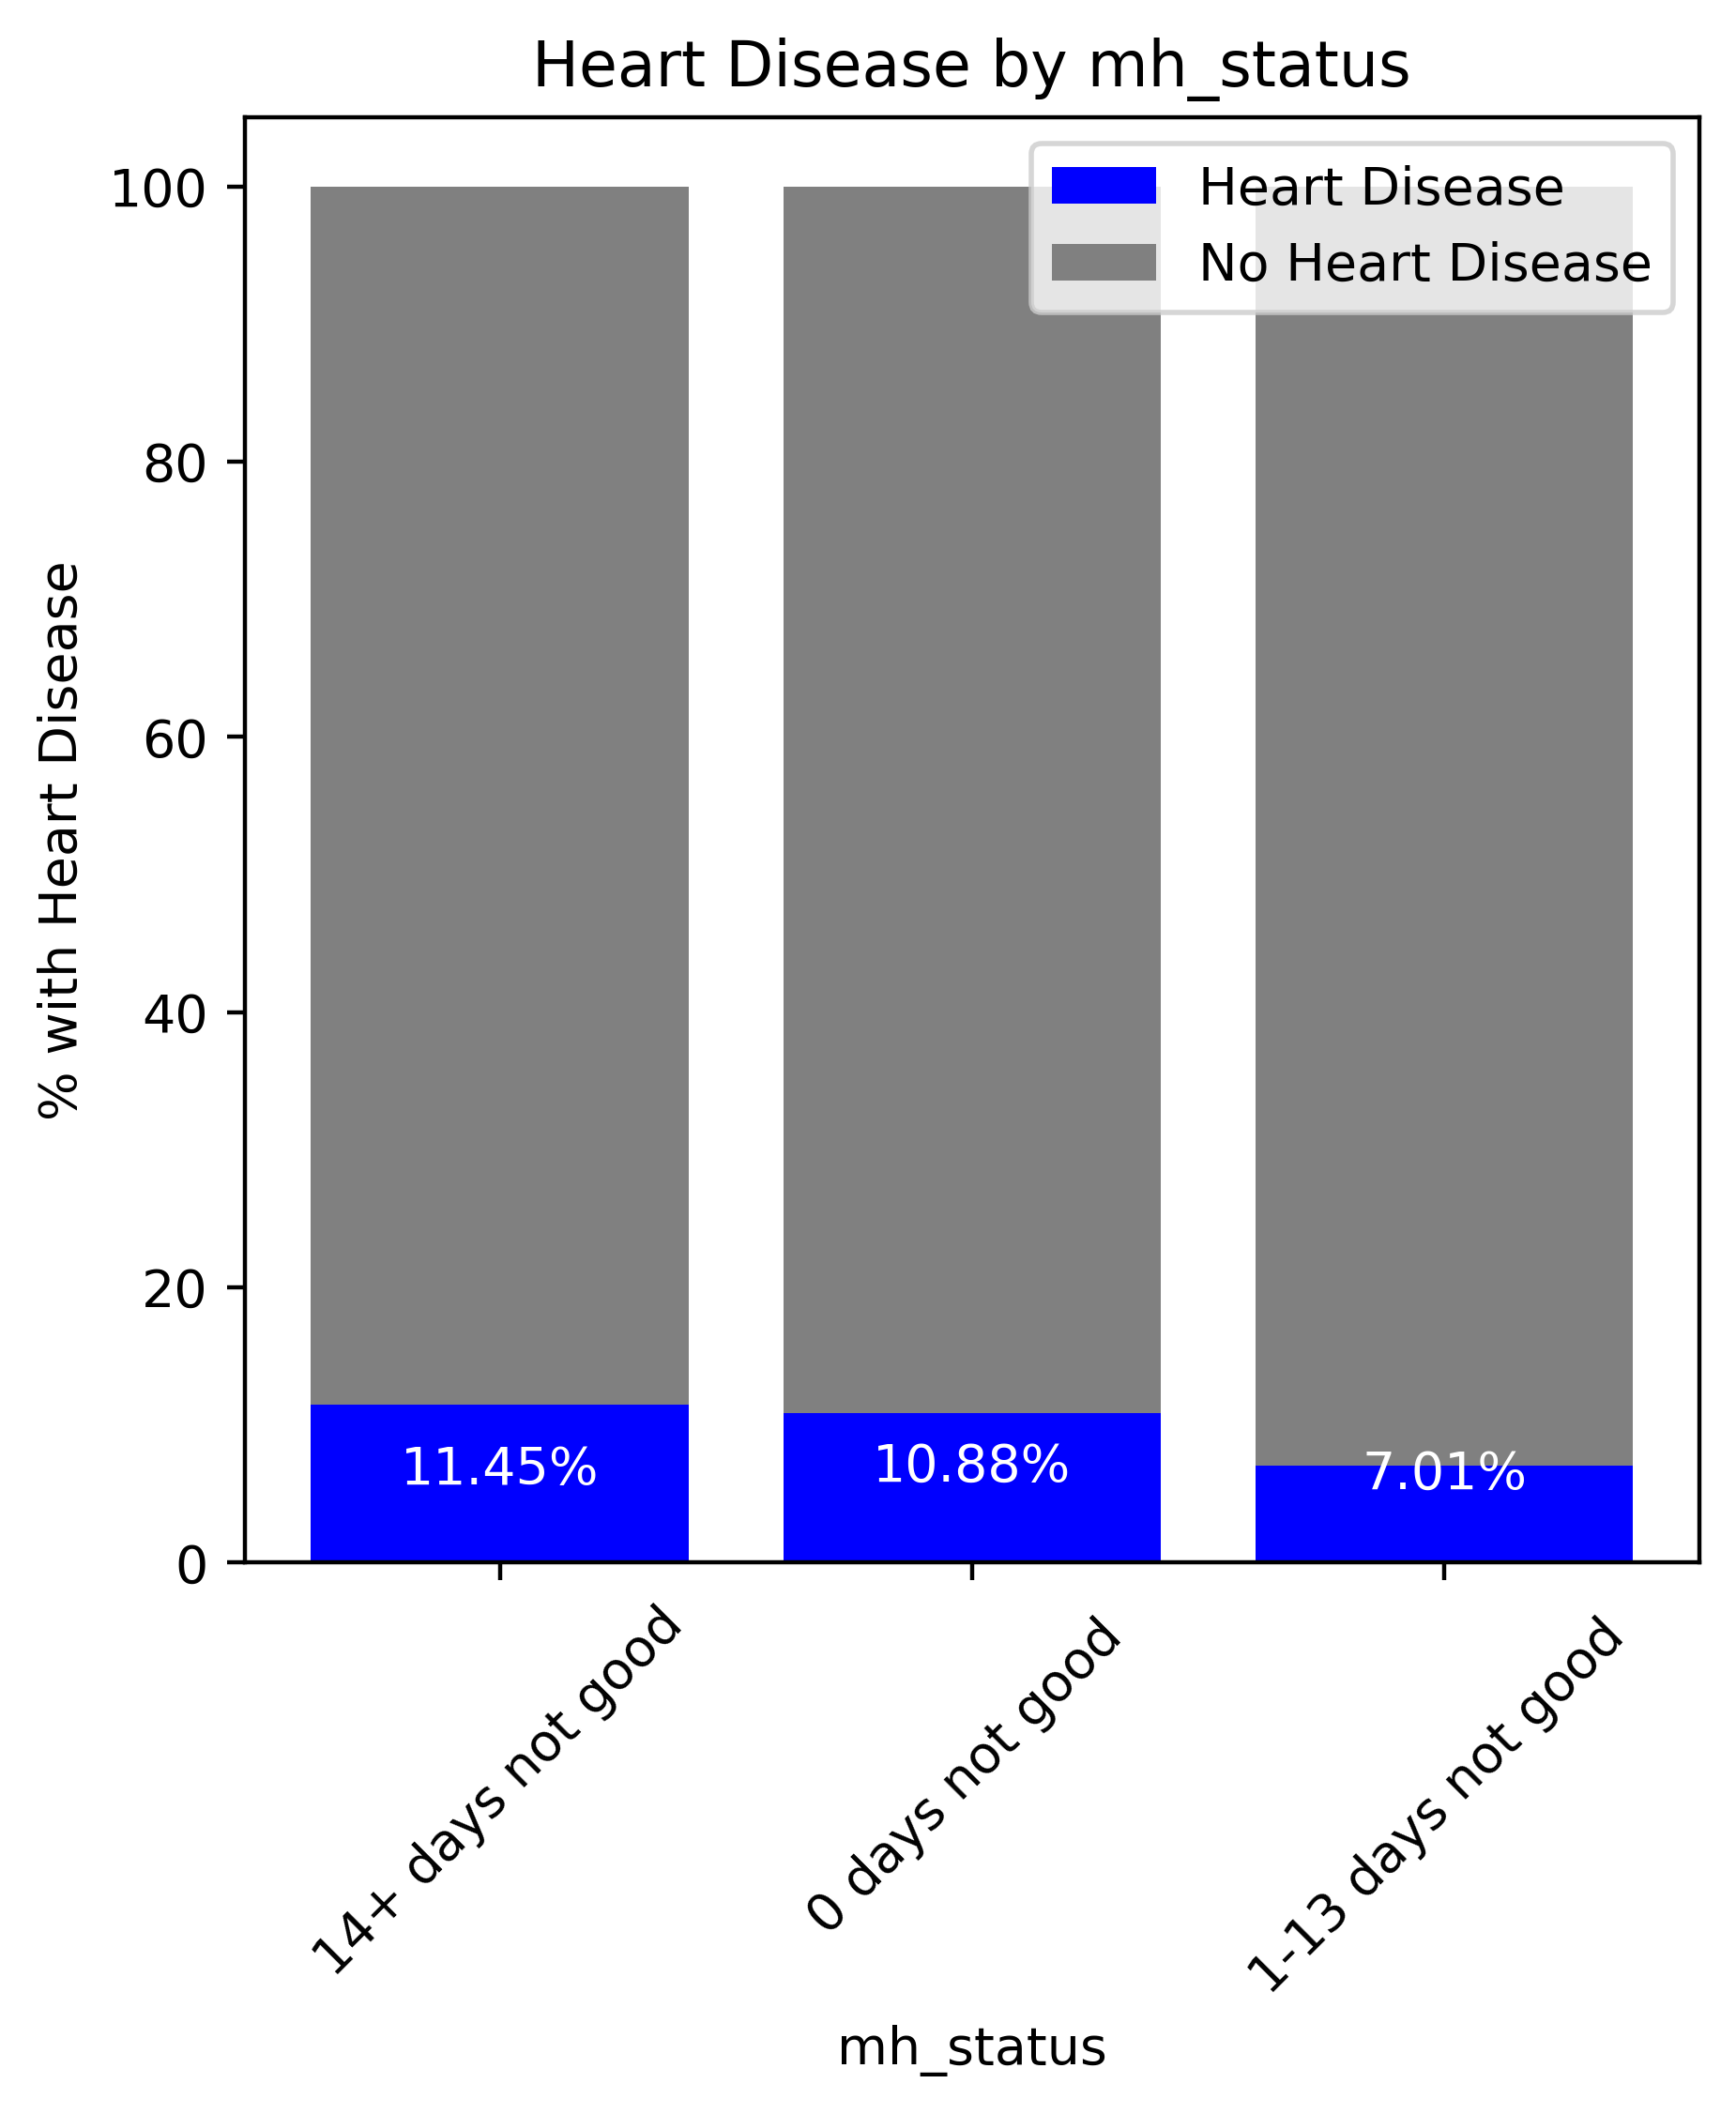

In [11]:
data_agg_viz(mh, 'mh_status', 45)

## Risk Factors

### Stroke
36.03% of users with heart disease answered that they have a history of stroke while 9.20% of them don't have any history.

A previous heart attack is a risk factor for a subsequent stroke. Most strokes happen when a piece of plaque or a blood clot blocks the flow of blood to the brain. Similarly, heart attacks are caused by blockages in the flow of blood to the heart.

Atherosclerosis, or the build-up of fatty plaque in the arteries, is the leading cause of heart attacks and strokes. It can prevent blood from reaching the heart and it contributes to the development of blood clots that can travel to the heart or brain.

Source: [Heart attack and stroke – is there a connection?](https://www.eehealth.org/blog/2016/05/heart-attack-stroke-connection/)

In [12]:
stroke = data_aggregation(heart_data_cl, 'stroke')
stroke

,stroke,total_population,heart_disease,%heart_disease,no_disease,%no_disease
1,Yes,9124,3065,33.59,6059,66.41
0,No,193230,16858,8.72,176372,91.28


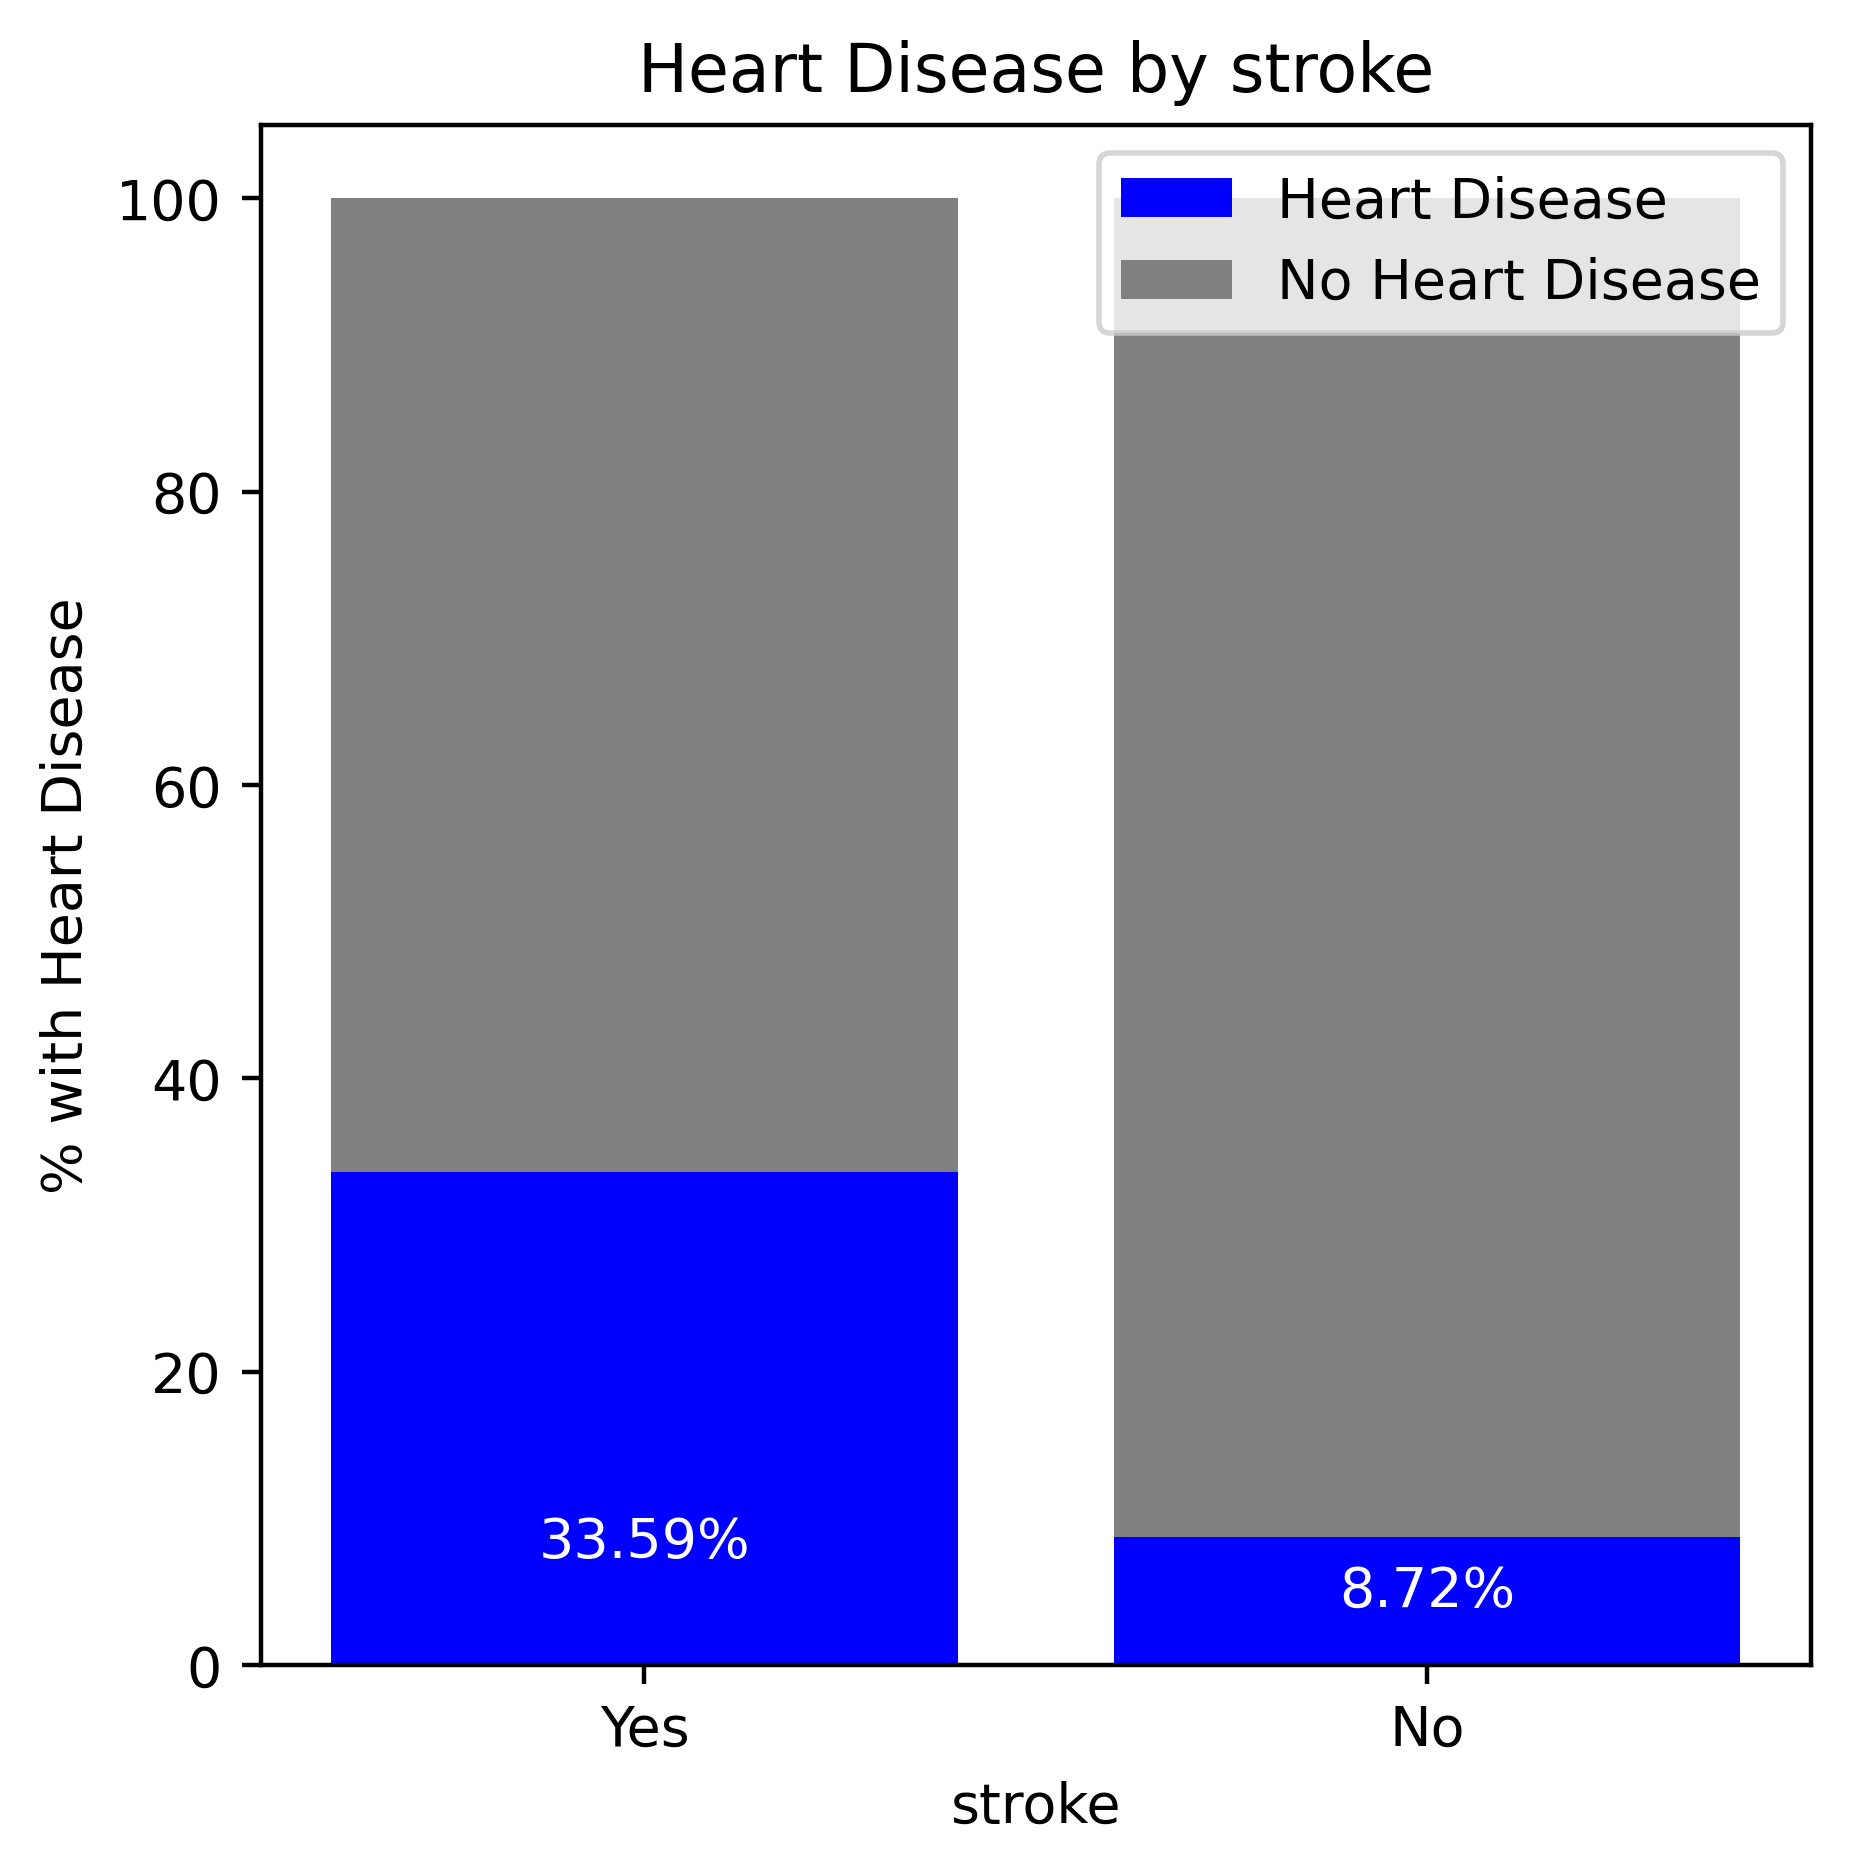

In [13]:
data_agg_viz(stroke, 'stroke')

### High Cholesterol
5.59% of users with heart disease answered that they have a history of high cholesterol while 16.50% of them don't have any history.

A possible reason is that they may not be aware of their condition or may not have been diagnosed yet of having high cholesterol.

In [14]:
high_chol = data_aggregation(heart_data_cl, 'high_chol')
high_chol

,high_chol,total_population,heart_disease,%heart_disease,no_disease,%no_disease
0,No,84931,13360,15.73,71571,84.27
1,Yes,117423,6563,5.59,110860,94.41


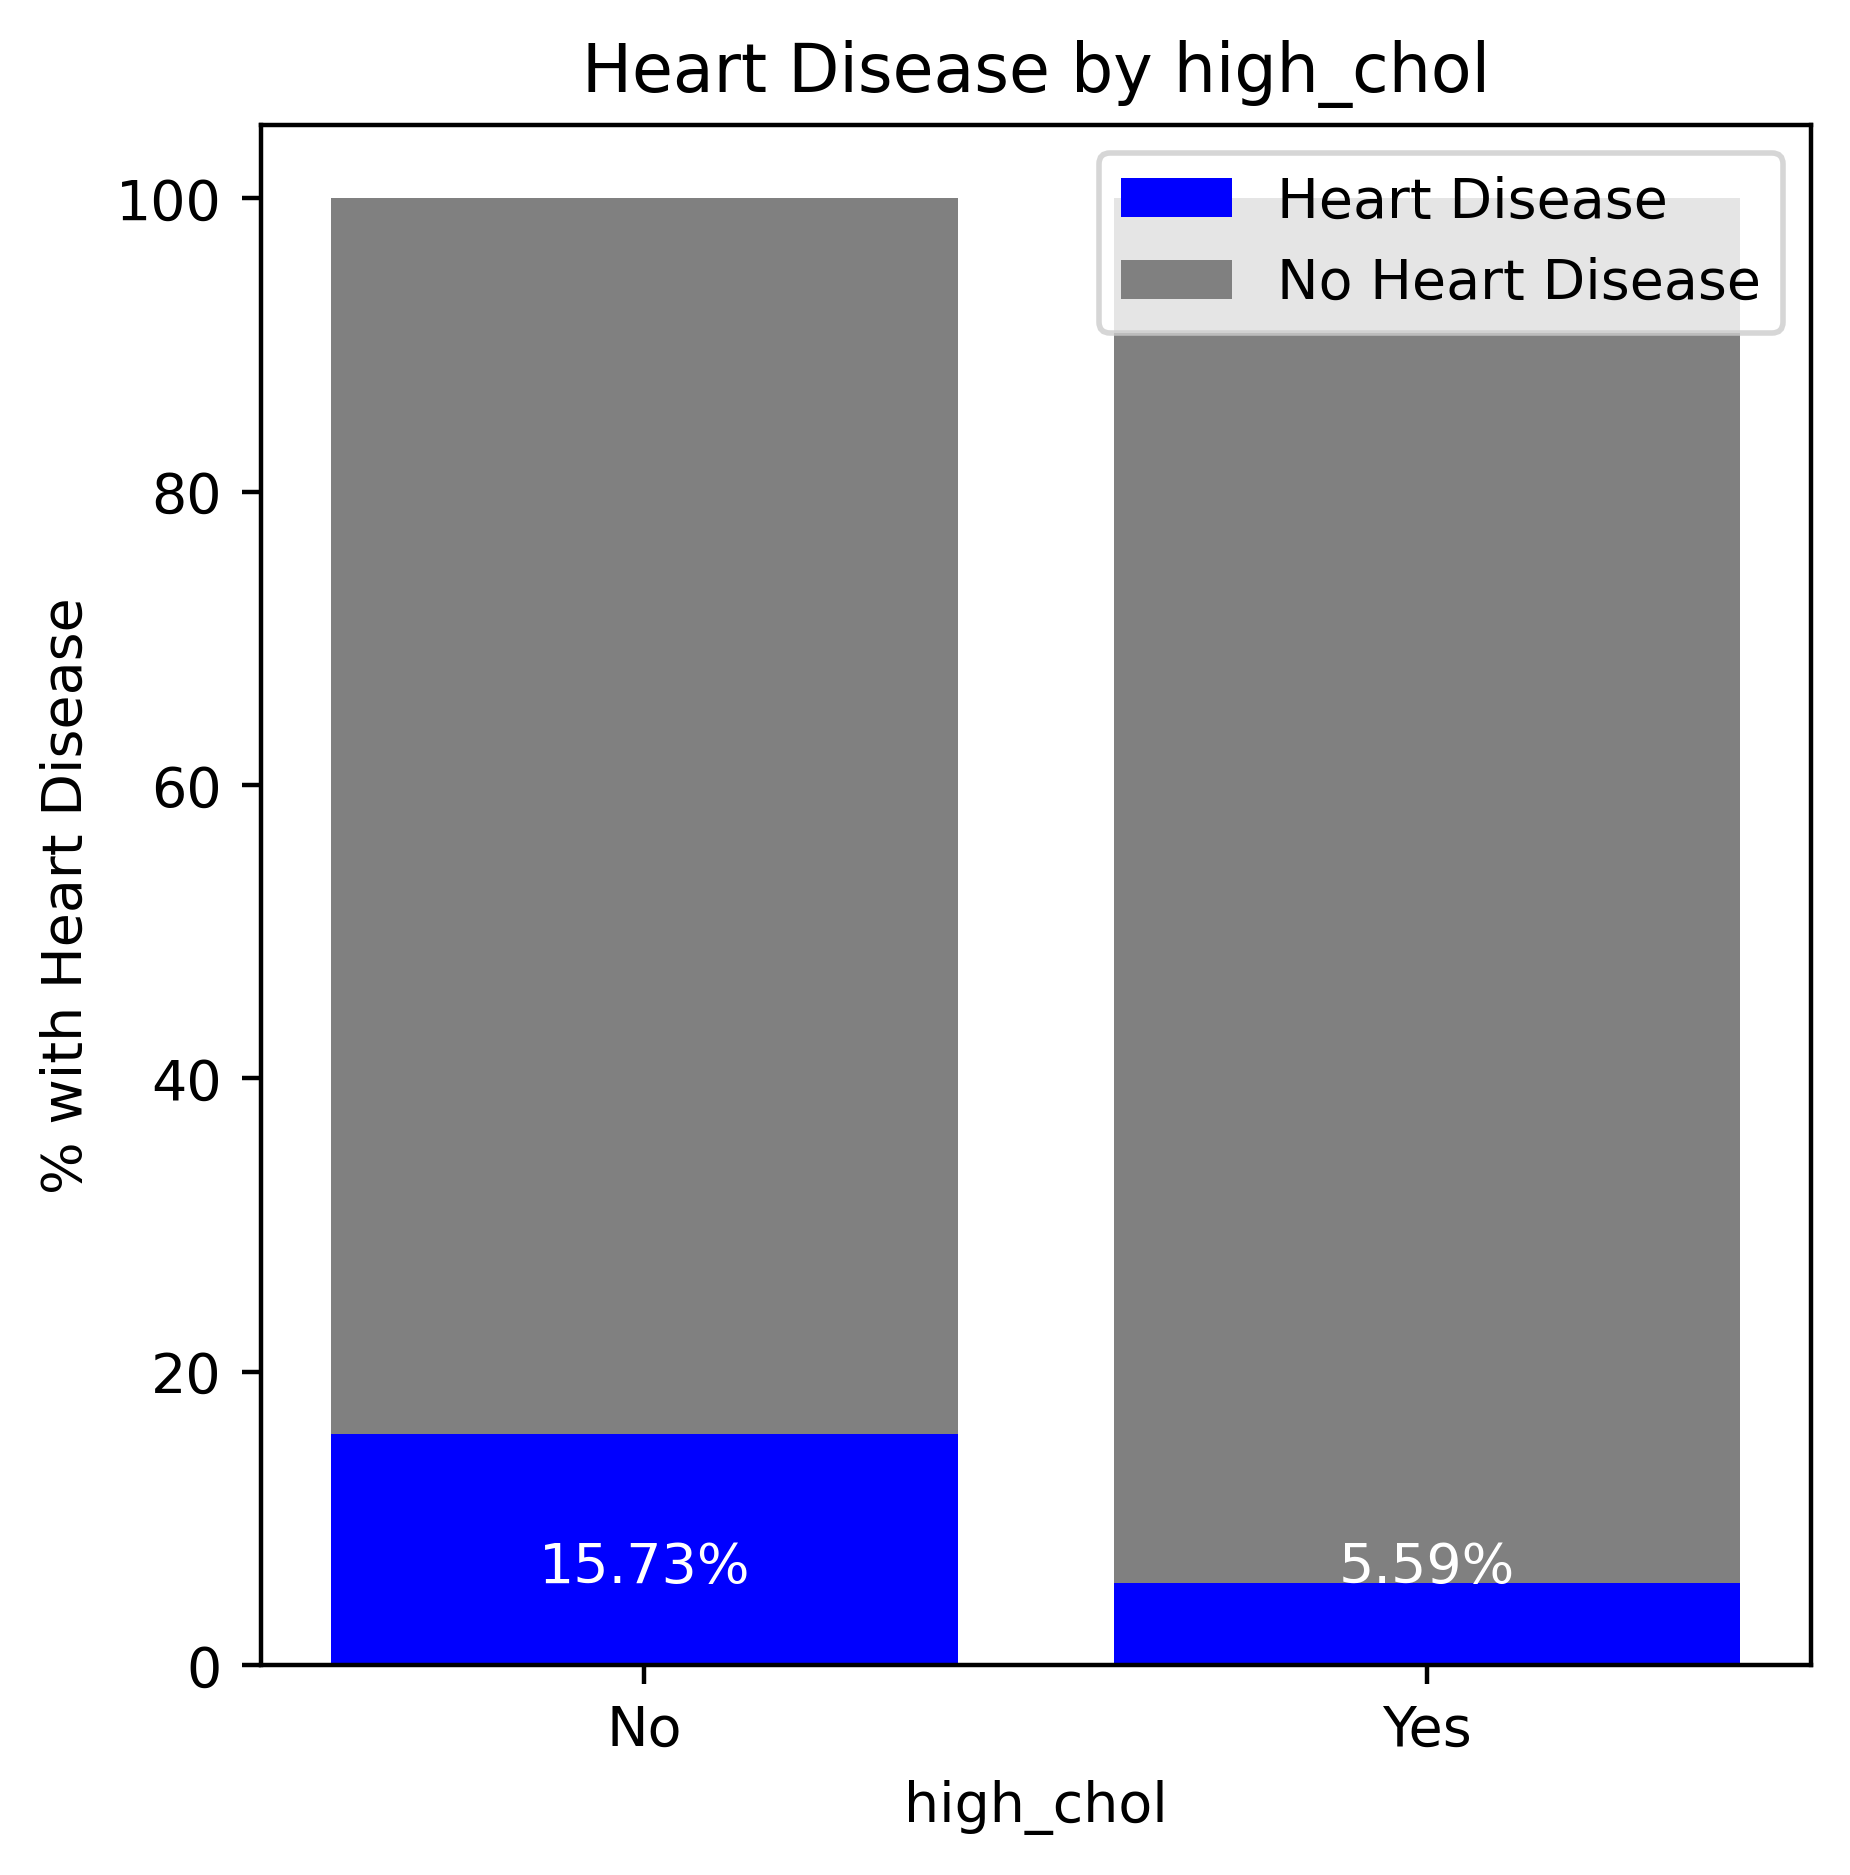

In [15]:
data_agg_viz(high_chol, 'high_chol')

### High Blood Pressure
18.09% of users with heart disease answered that they have a history of high blood pressure while 4.56% of them don't have any history. 

High blood pressure can damage the arteries by making them less elastic, which decreases the flow of blood and oxygen to your heart and leads to heart disease. As it puts extra strain on the heart and blood vessels, over time, this can damage the heart and blood vessels, making them less effective at doing their job.

Source: [High Blood Pressure Symptoms and Causes](https://www.cdc.gov/bloodpressure/about.htm)

In [16]:
high_bp = data_aggregation(heart_data_cl, 'high_bp')
high_bp

,high_bp,total_population,heart_disease,%heart_disease,no_disease,%no_disease
1,Yes,89941,14804,16.46,75137,83.54
0,No,112413,5119,4.55,107294,95.45


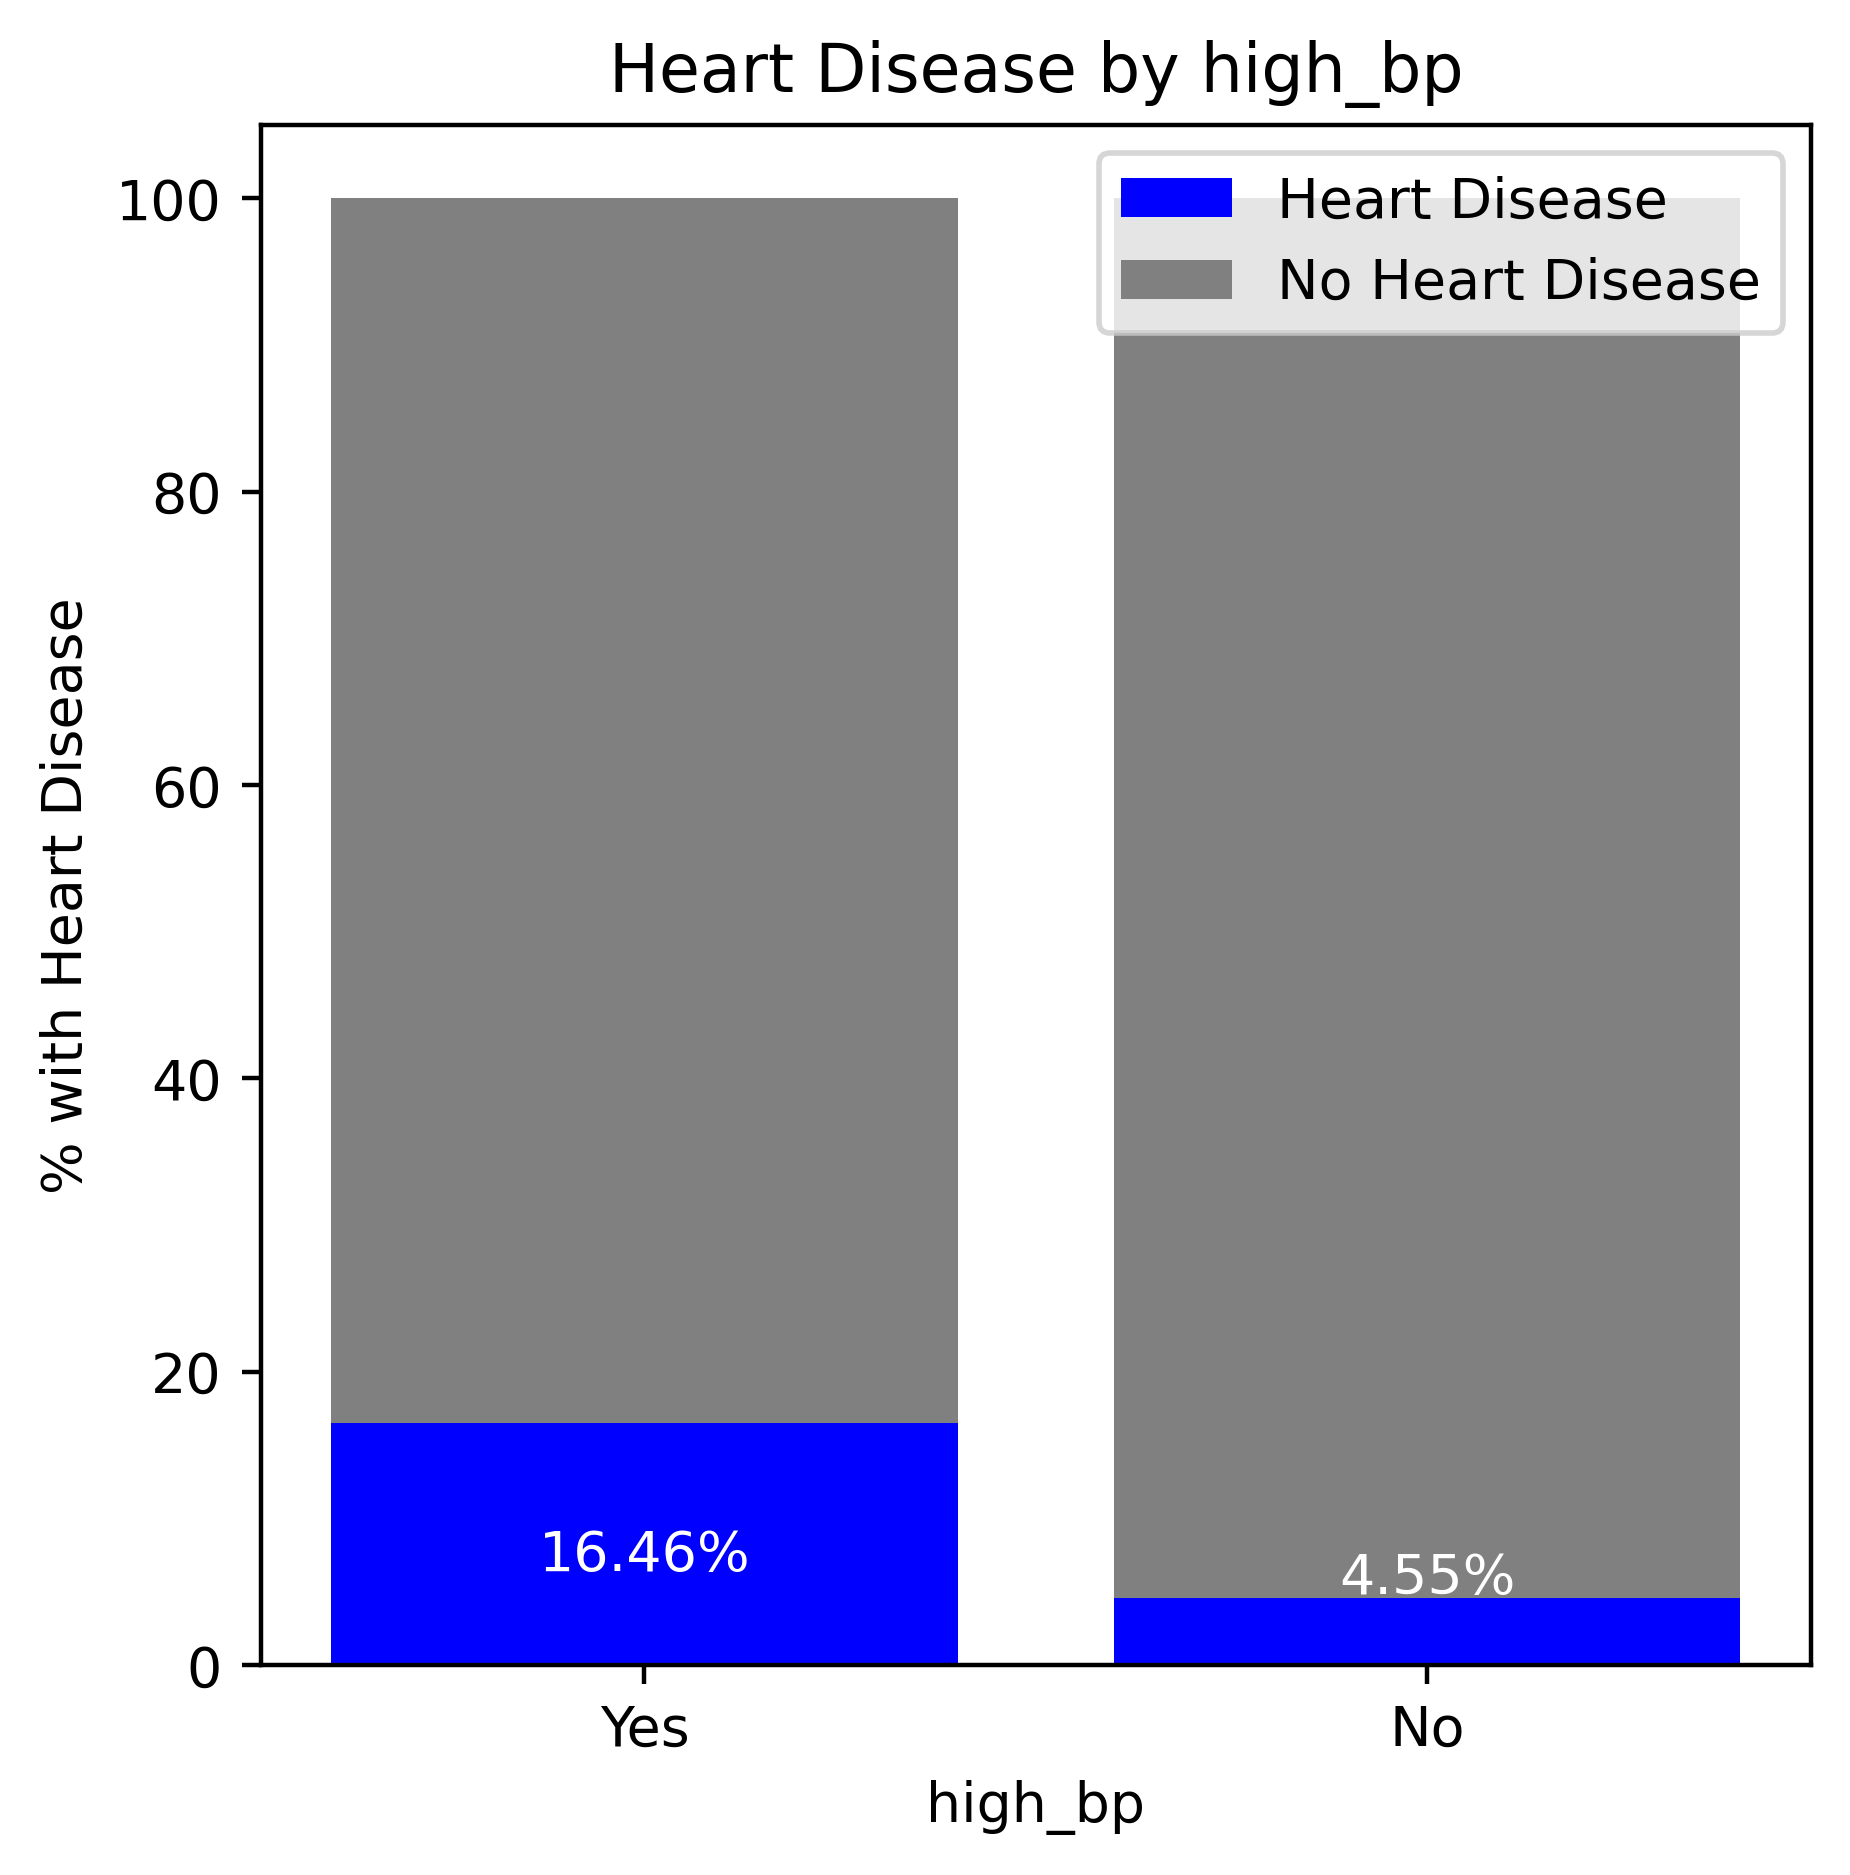

In [17]:
data_agg_viz(high_bp, 'high_bp')

### BMI
12.14% of users with heart disease answered that they belong to obese class 2 while 8.34% of them have normal BMI. 

The extra weight in obese people forces the heart to do more work. It can also cause problems by increasing the risk of developing many other factors that make heart disease more likely. High blood pressure, unhealthy cholesterol levels, and even diabetes have been linked to obesity. 

Underweight individuals are at risk for cardiac abnormalities. Regular heart rhythm depends on a proper balance of minerals such as potassium, sodium and calcium inside and outside of the heart muscle cells. The chronic malnutrition associated with a low BMI disrupts this balance. Furthermore, an insufficient diet can cause the body to break down heart muscle to use for energy, further weakening your heart.

Source: 
* [The Connection between Obesity and Cardiovascular Disease](https://www.slma.cc/the-connection-between-obesity-and-cardiovascular-disease/)
* [Health Risks of a Low BMI](https://healthyeating.sfgate.com/health-risks-low-bmi-5687.html)

In [18]:
bmi = data_aggregation(heart_data_cl, 'bmi_category')
bmi

,bmi_category,total_population,heart_disease,%heart_disease,no_disease,%no_disease
2,Obese 2,22060,2396,10.86,19664,89.14
1,Obese 1,48001,5103,10.63,42898,89.37
4,Overweight,67941,6894,10.15,61047,89.85
3,Obese 3,15596,1578,10.12,14018,89.88
5,Underweight,2740,239,8.72,2501,91.28
0,Normal,46016,3713,8.07,42303,91.93


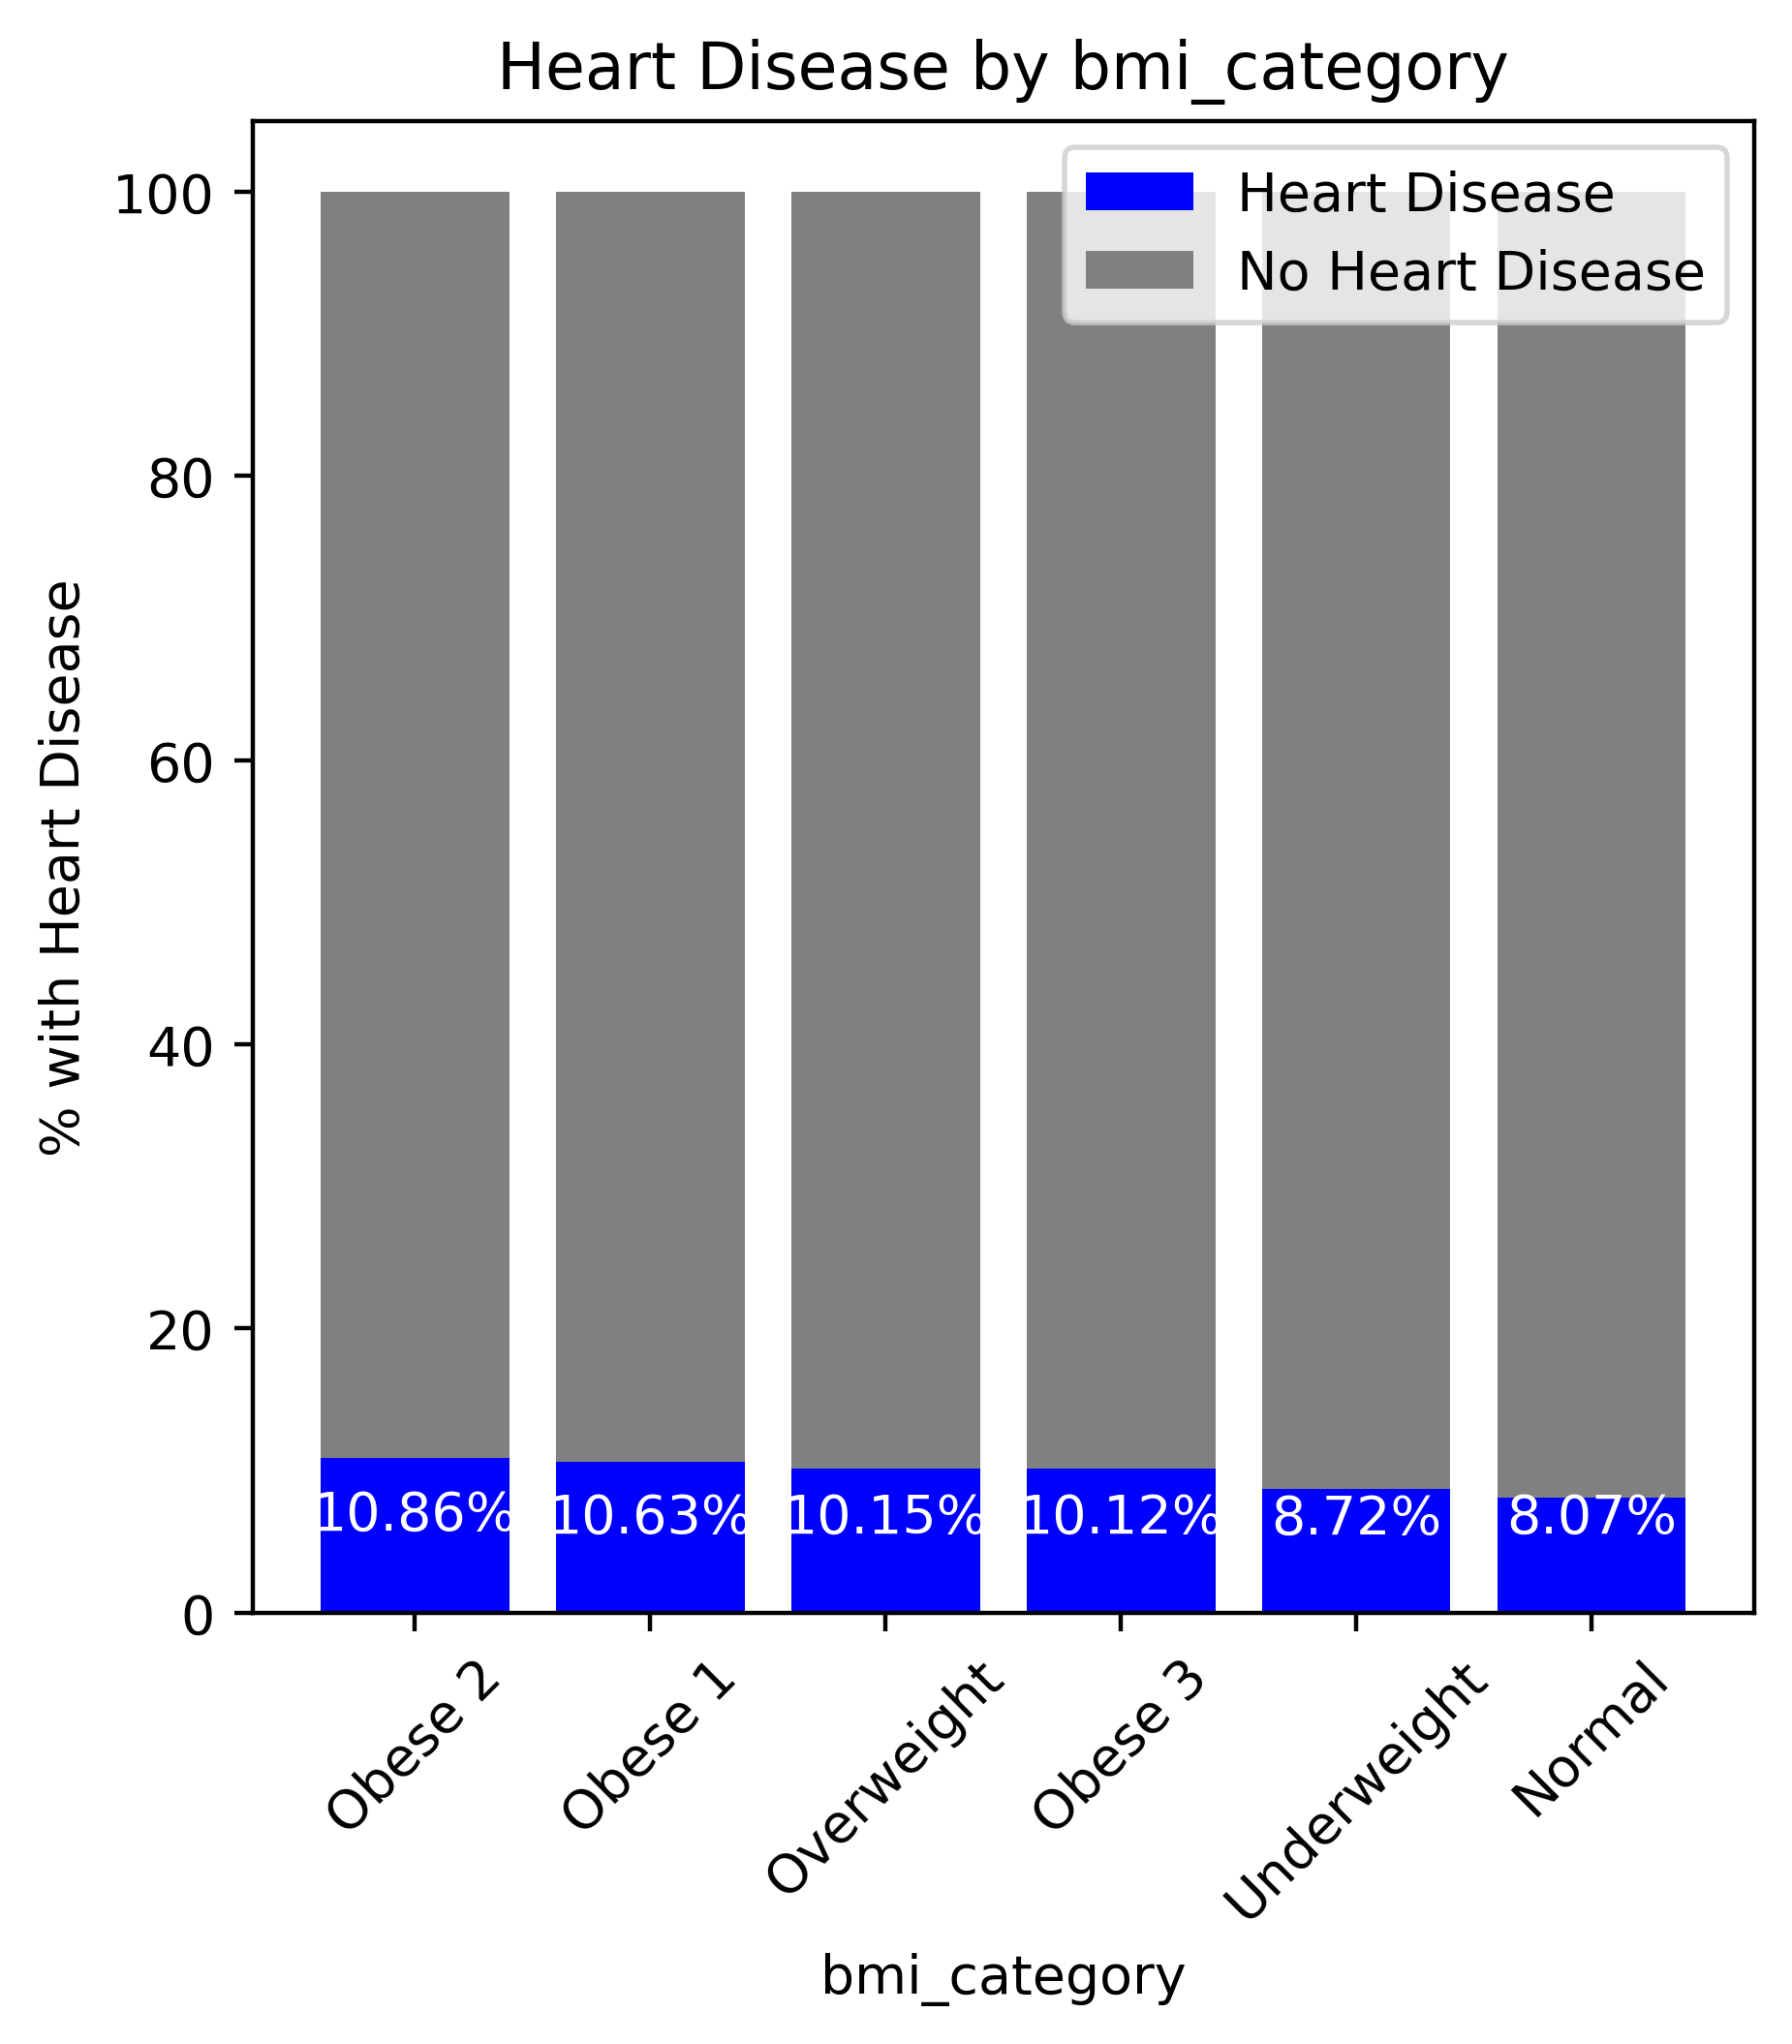

In [19]:
data_agg_viz(bmi, 'bmi_category', rotation=45)

### Diabetes
23.80% of users with heart disease answered that they have existing diabetes while 7.69% of them don't have any history or only got it during pregnancy (for females).

High blood glucose from diabetes can damage the blood vessels and the nerves that control your heart and blood vessels. Over time, this damage can lead to heart disease.

Source: [Diabetes, Heart Disease, & Stroke](https://www.niddk.nih.gov/health-information/diabetes/overview/preventing-problems/heart-disease-stroke)

In [20]:
diabetes = data_aggregation(heart_data_cl, 'diabetes_category')
diabetes

,diabetes_category,total_population,heart_disease,%heart_disease,no_disease,%no_disease
0,Existing Diabetes,32643,6890,21.11,25753,78.89
2,Pre-Diabetes/Borderline,5551,658,11.85,4893,88.15
1,No or During Pregnancy,164160,12375,7.54,151785,92.46


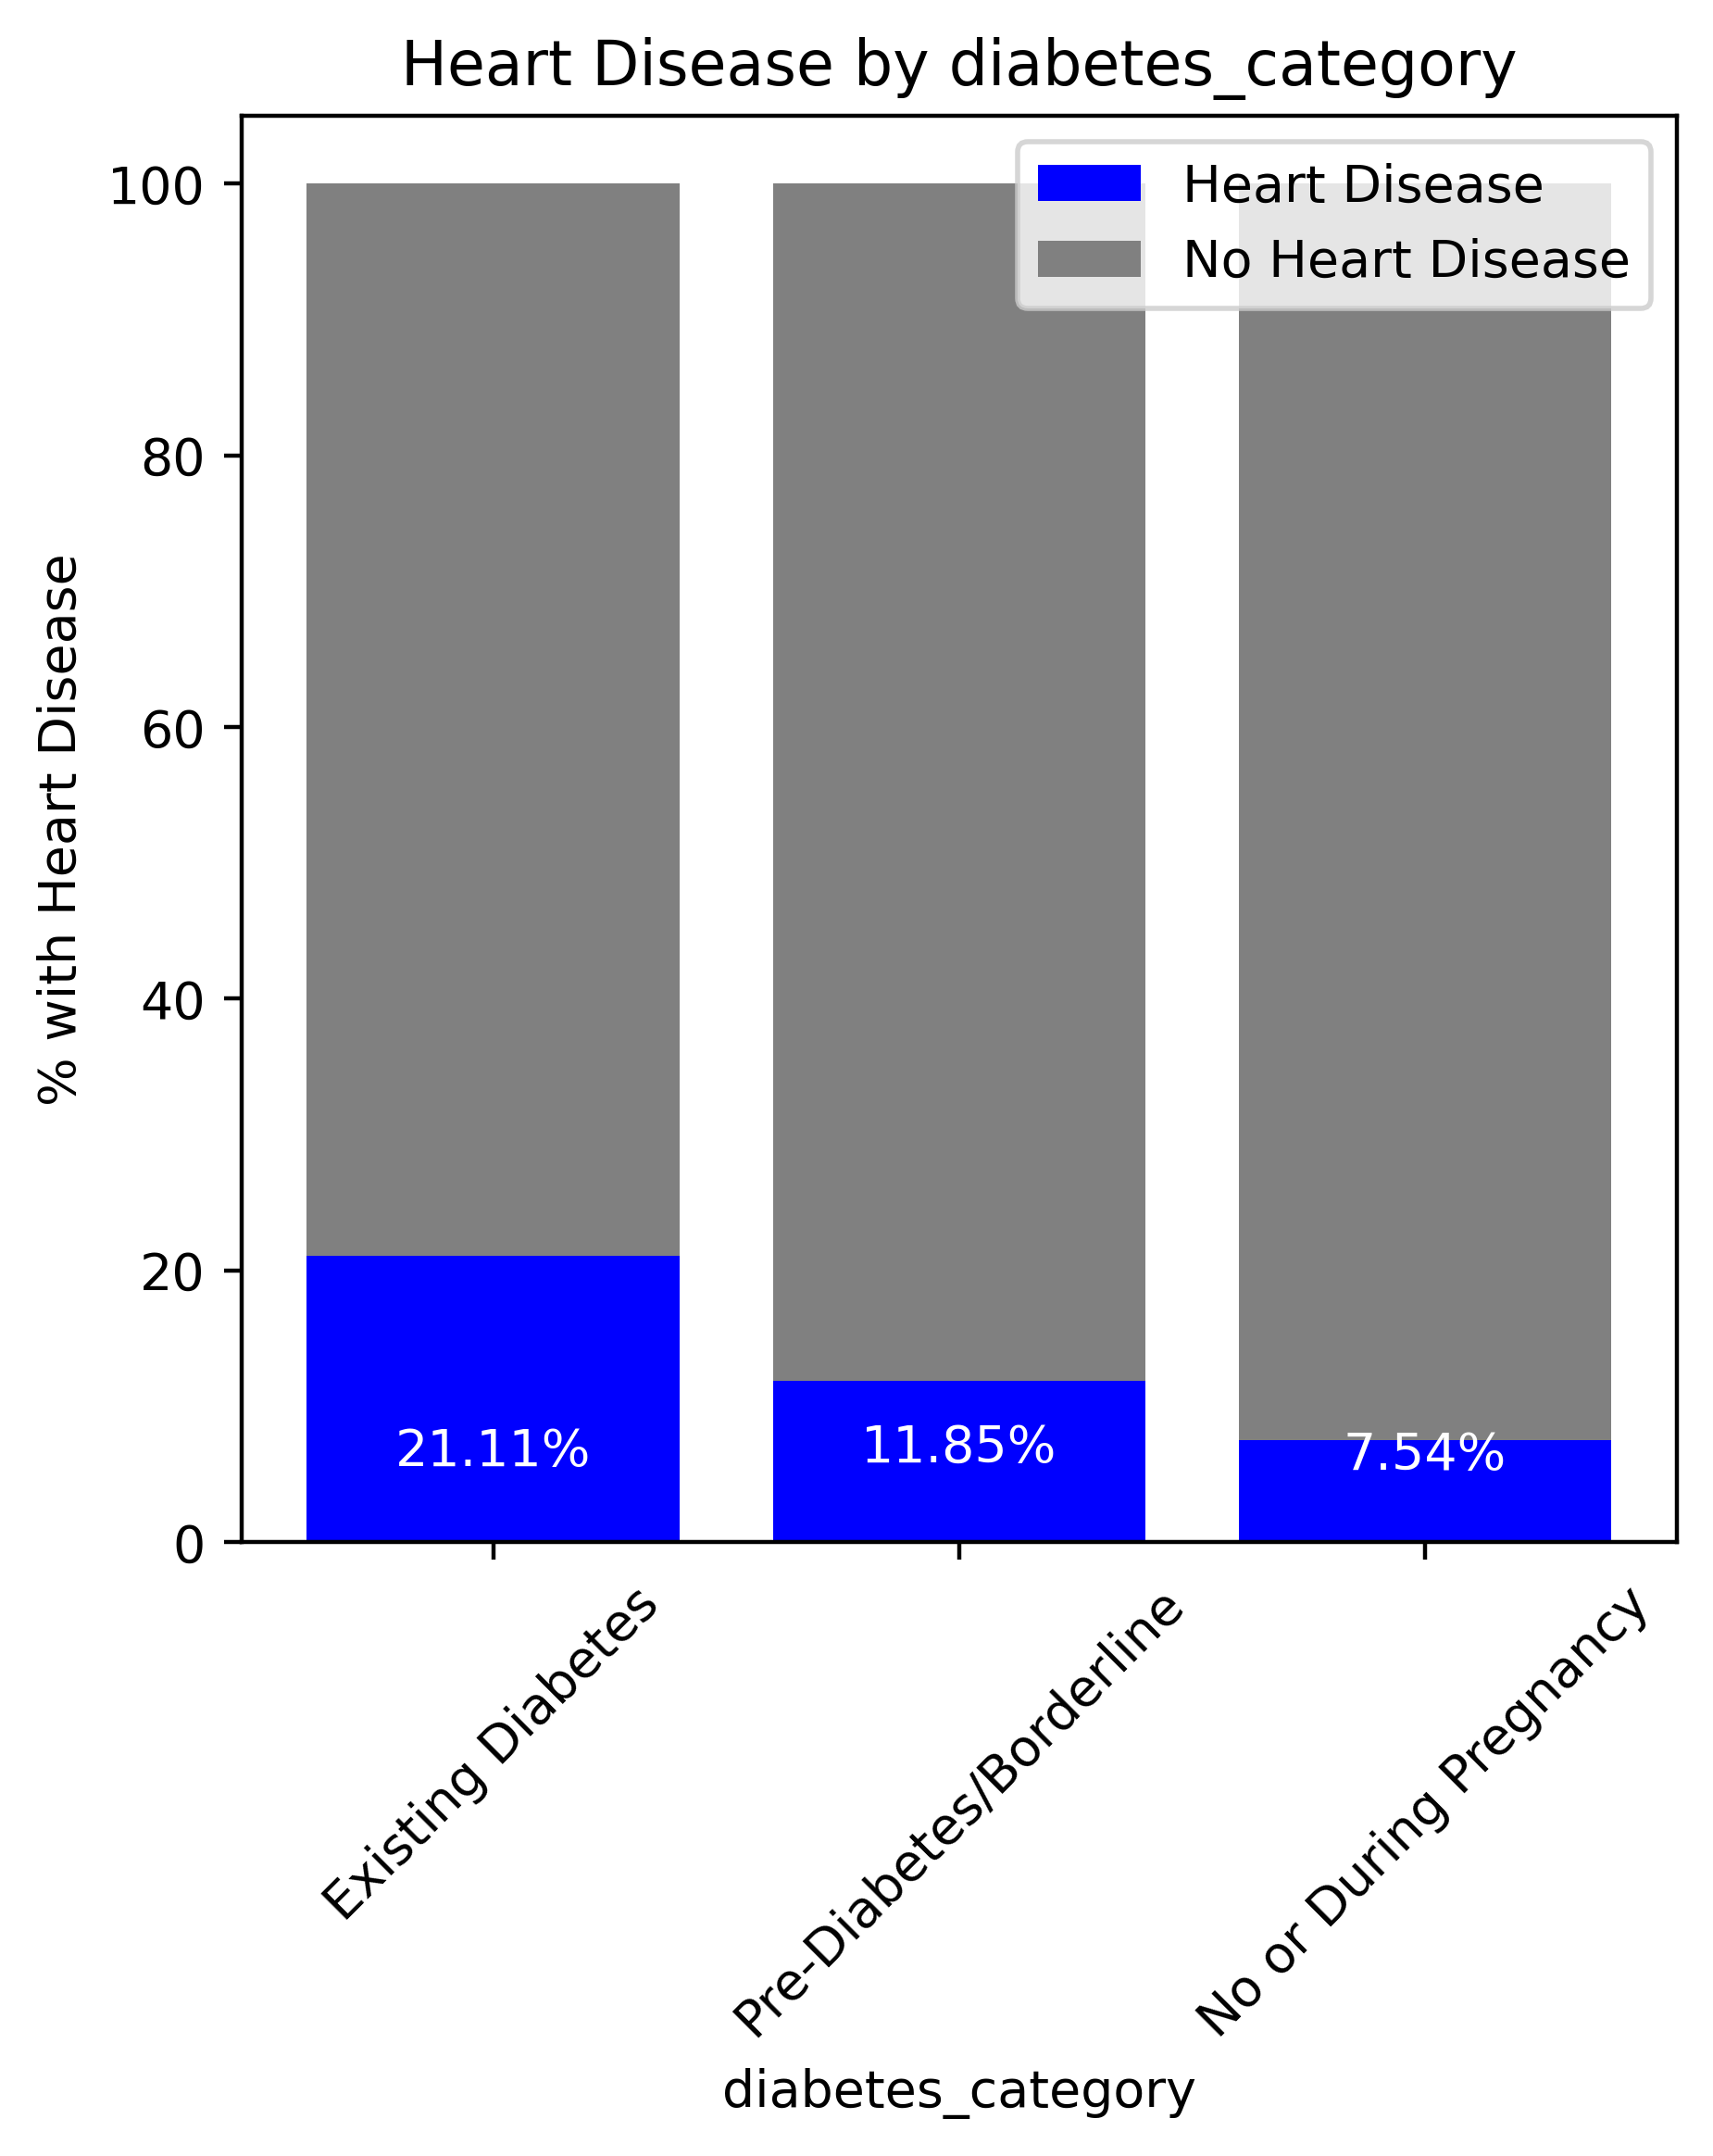

In [21]:
data_agg_viz(diabetes, 'diabetes_category', rotation=45)

## Healthcare Access

### Health Insurance
10.82% of users with heart disease answered that they have health insurance while 8.48% of them don't have any.

Even with health insurance, individuals may face barriers to accessing appropriate medical care and follow-up. Also, they may not prioritize preventive health measures which can help identify and manage risk factors for heart disease.

In [22]:
health_insurance = data_aggregation(heart_data_cl, 'health_insurance')
health_insurance

,health_insurance,total_population,heart_disease,%heart_disease,no_disease,%no_disease
1,Yes,193595,19478,10.06,174117,89.94
0,No,8759,445,5.08,8314,94.92


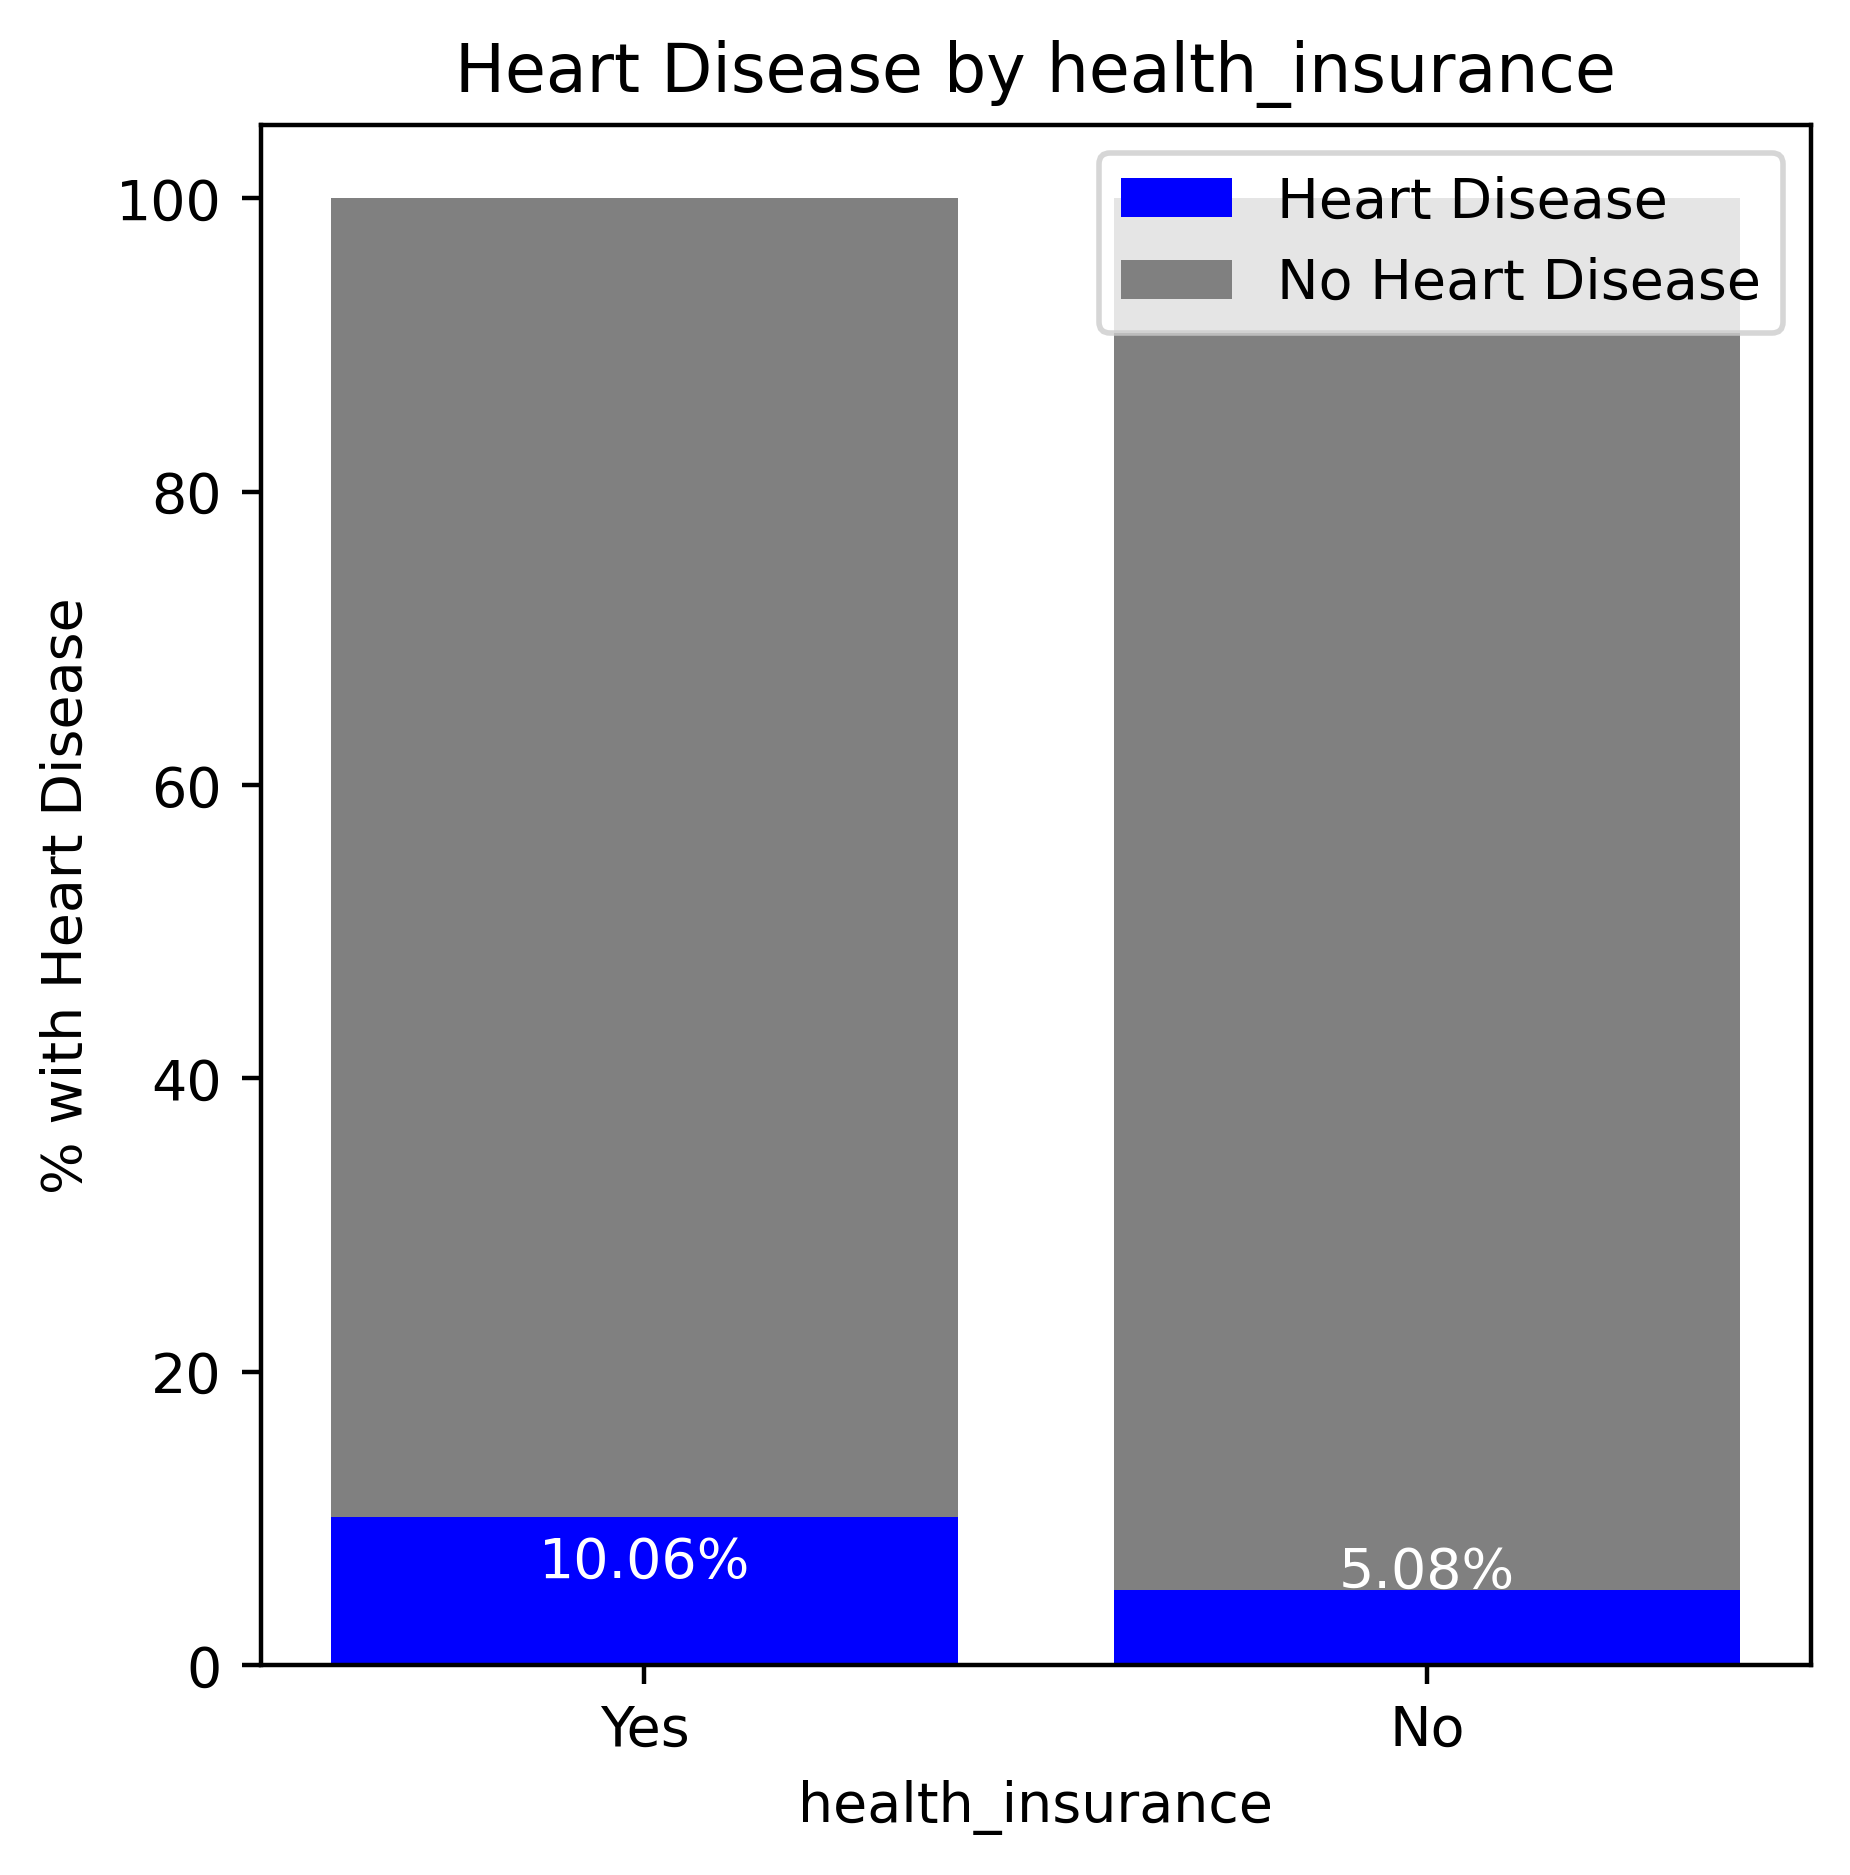

In [23]:
data_agg_viz(health_insurance, 'health_insurance')

### Could Not Afford to See a Doctor
12.24% of users with heart disease answered that they cannot afford to see a doctor while 10.50% of them can.

People that cannot afford to see a doctor may be less likely to seek preventive care or manage risk factors for heart disease, leading to a higher risk of developing the condition.

In [24]:
no_doc_cost = data_aggregation(heart_data_cl, 'no_doc_cost')
no_doc_cost

,no_doc_cost,total_population,heart_disease,%heart_disease,no_disease,%no_disease
1,Yes,14947,1528,10.22,13419,89.78
0,No,187407,18395,9.82,169012,90.18


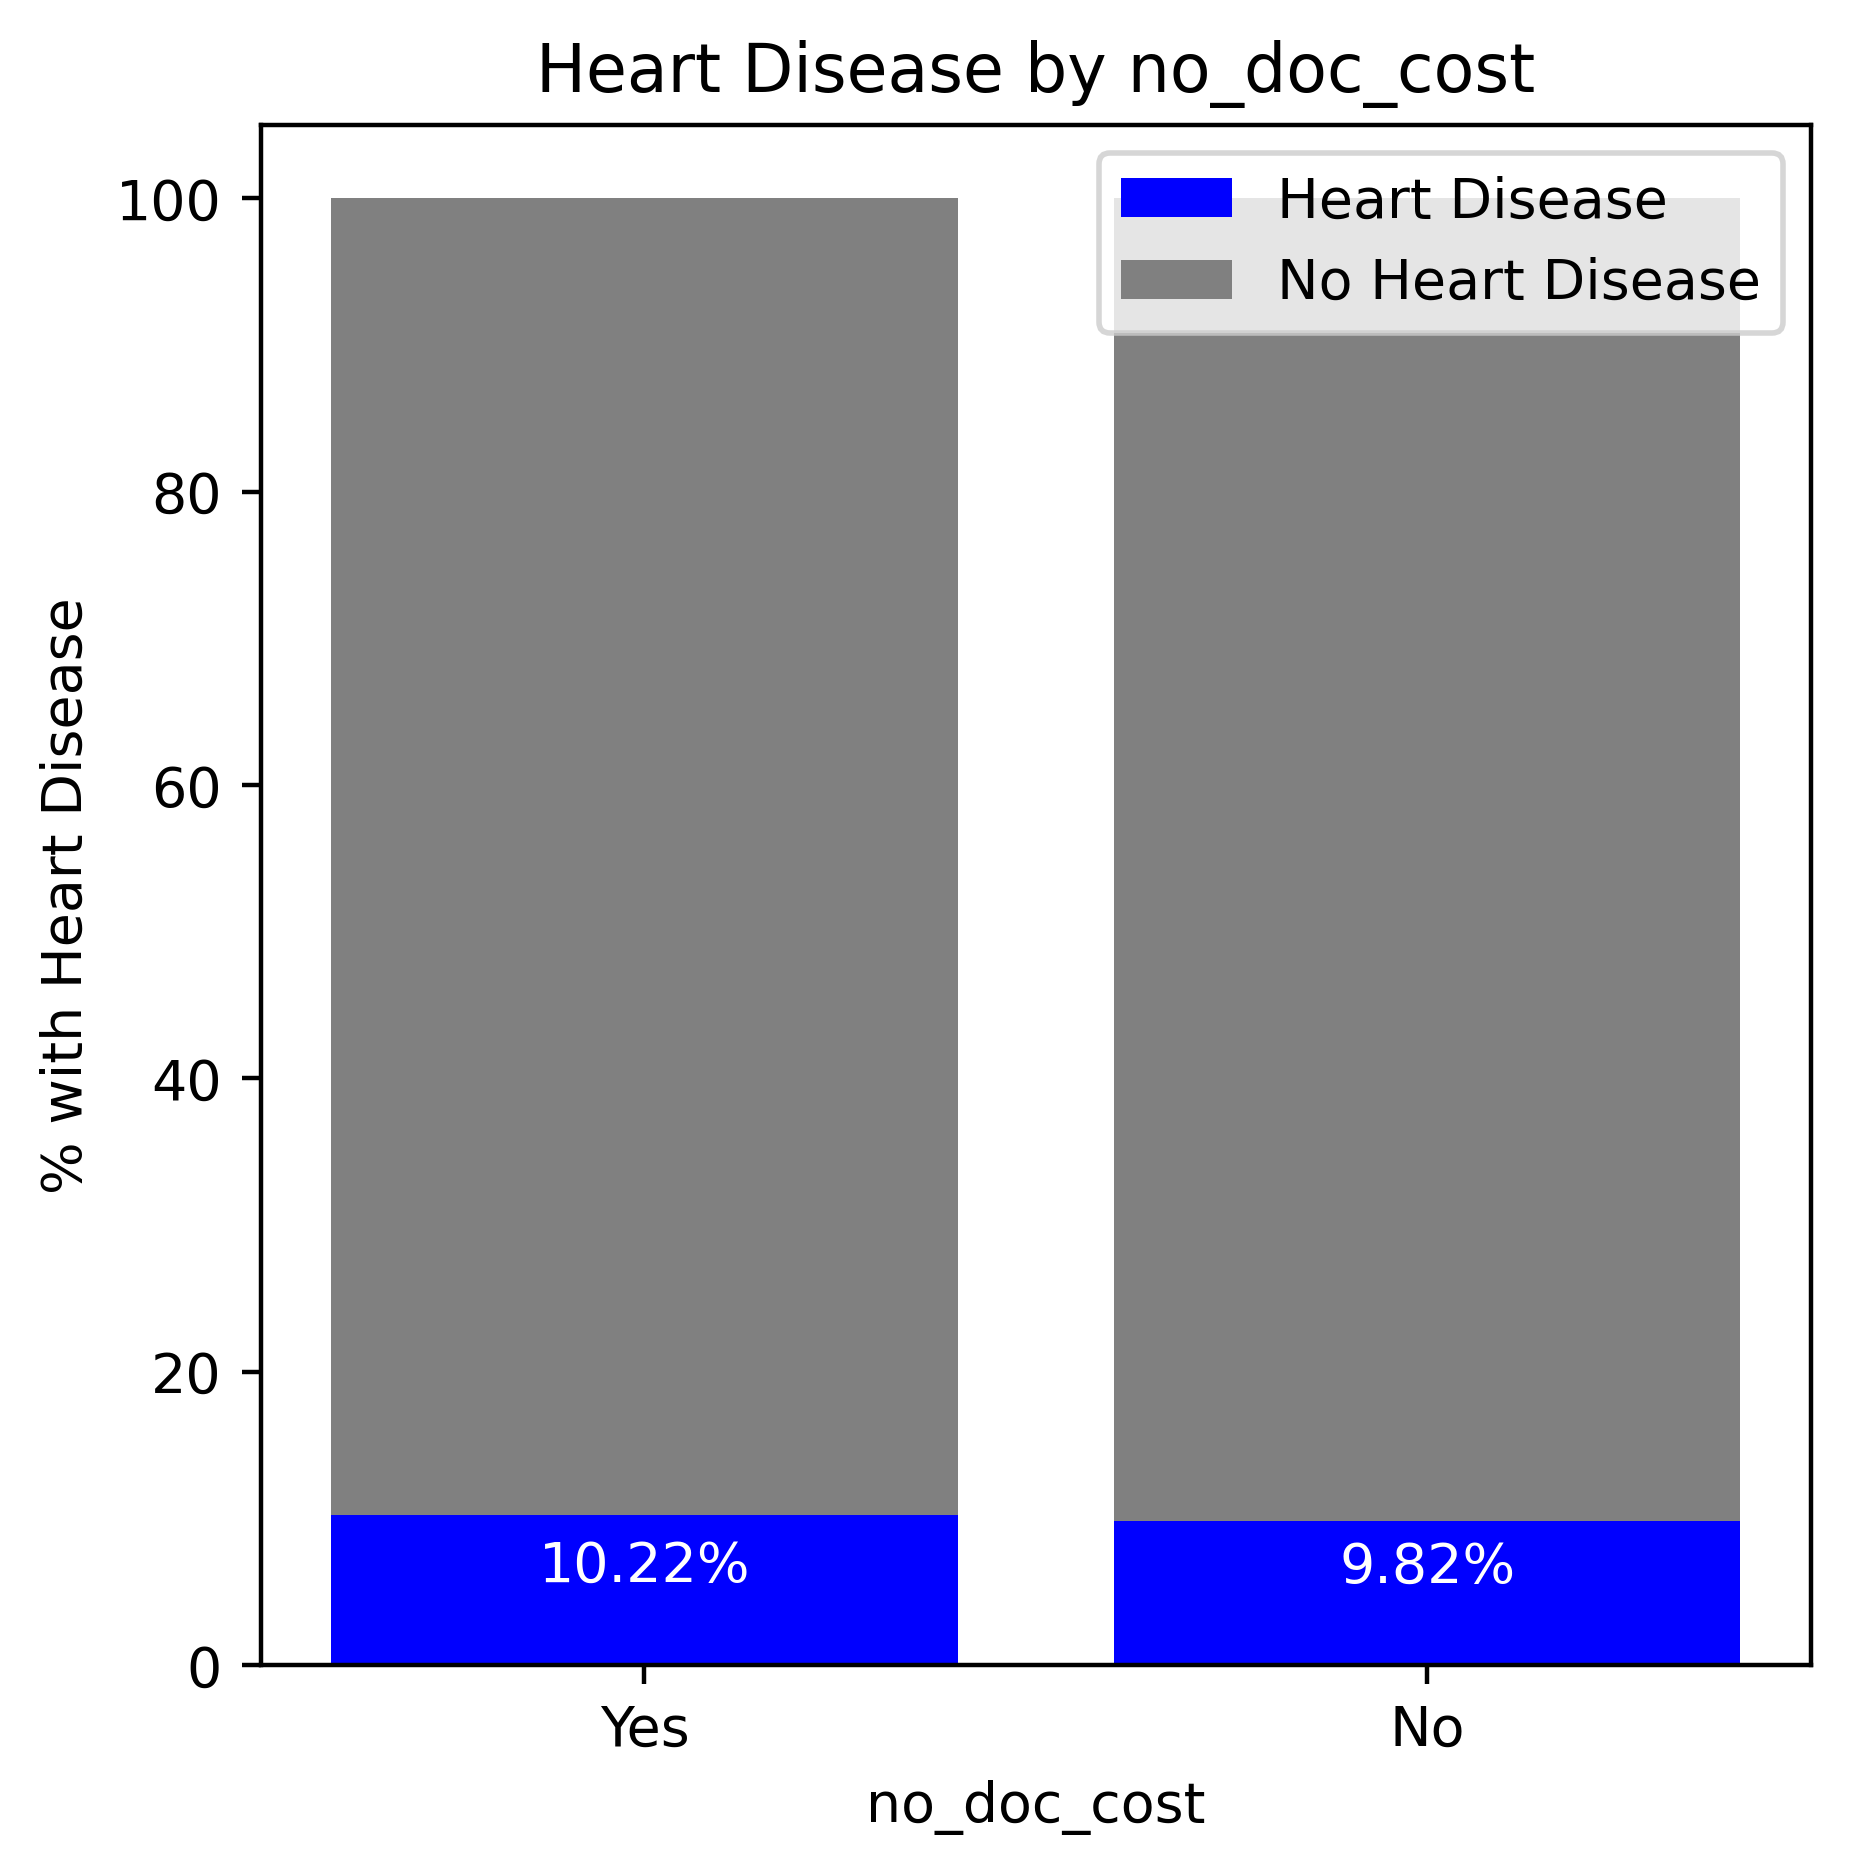

In [25]:
data_agg_viz(no_doc_cost, 'no_doc_cost')